<a href="https://colab.research.google.com/github/tewed/projects/blob/main/Paysim_Fraud/Paysim_Fraud_Detection_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Paysim Fraud Detection**

The aim of this project is to identify fraudulent transactions contained in a synthetic dataset originally presented in the paper:  
 [PAYSIM: A FINANCIAL MOBILE MONEY SIMULATOR FOR FRAUD DETECTION](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION)  

This dataset is a subset of that dataset and was sourced from [Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1/data), and has been downscaled to 1/4 of the original dataset.  

# **Ethical considerations**

*  Prior to beginning any analysis, we need to determine if there are any ethical issues that might arise, considering the project at hand.

*  In this instance, we are predicting whether or not a transaction is fraudulent.

*  The project as a whole, does not appear to target anything that might be considered unethical - you would like to prevent all people from having their money stolen (vs just a subgroup).  The data has also been anonymised and simulated, so investigating the outcomes for specific biases will be difficult.

*  I also believe that my analysis will have minimal risk of being adapted and used for nefarious purposes.

Considering this, I believe the analysis can go forward.


The dataset contains several columns:  



* **step** : Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).  
* **type** : The Type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER."
* **amount** : Amount of the transaction in local currency.  
* **nameOrig**  : Customer who started the transaction
* **oldbalanceOrg**  : Initial balance before the transaction.  
* **newbalanceOrig**  : New balance after the transaction.  
* **nameDest**  : Customer who is the recipient of the transaction.  
* **oldbalanceDest** : Initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).  
* **newbalanceDest**  : New balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).  
* **isFraud**  : This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.  
* **isFlaggedFraud**  : The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200 000 in a single transaction.  



*A notable consideration in the analysis, is that transactions which are detected as fraud are cancelled, so for fraud detection the columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used, as per the [dataset source](https://www.kaggle.com/datasets/ealaxi/paysim1/data)*.



---



This analysis has also been replicated using Pandas and SKLearn.

*I have since learned that there is a pandas API within pyspark, however I did not use it in this, however I would likely use it in future*

# **Importing packages**

Something to note is that specific packages used in modeling, will be imported down the line, else they will be noted in the comments

In [ ]:
import time
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as psf
import pandas as pd
from functools import reduce
# Import the necessary packages for one hot encoding of the transaction_types
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer


import matplotlib.pyplot as plt
import seaborn as sns

# To be used in data manipulation
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import substring, greatest, col, log, countDistinct

# Used to calculate missing values in the data
from pyspark.sql.functions import isnan, when, count, col

In [ ]:
# Set options for packages imported
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8-colorblind')
sns.set(font_scale = 1.25)

#The same seed be used for all randomisation
seed = 1234
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

## Print versions of major packages used

In [ ]:
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("pyspark version:", pyspark.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
pandas version: 2.2.2
seaborn version: 0.13.2
numpy version: 2.0.2
matplotlib version: 3.10.0
pyspark version: 3.5.5


Create a Spark Context, and naming the app

In [ ]:
# Configure the session to use 8GB of memory for driver, 10gb for the executor,
# and allow them to use both cores
spark = SparkSession.builder.appName('Paysim_Fraud_Detection')\
                            .config("spark.executor.memory", "10g") \
                            .config("spark.driver.memory", "8g") \
                            .config("spark.executor.cores", "4")\
                            .getOrCreate()
sc = SparkContext.getOrCreate()



---



# **Importing the Data**

In [ ]:
# Mount the google drive, to allow import of the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import using pandas to read the CSV file from google drive
data_path = '/content/drive/MyDrive/Data/Paysim Fraud Detection/PS_20174392719_1491204439457_log.csv'
# defining smaller datatypes (ex int32 vs int64), reduces memory usage in cases where it is not needed
panda_df = pd.read_csv(data_path, dtype={'step': 'int32',
                                         'type':'str',
                                         'amount':"float32",
                                         'nameOrig':"str",
                                         'oldbalanceOrg':"float32",
                                         'newbalanceOrig':"float32",
                                         'nameDest':'str',
                                         'oldbalanceDest':"float32",
                                         'newbalanceDest':"float32",
  # not converting these to boolean, as I want it an indicator variable in spark
                                         'isFraud':'int8',
                                         'isFlaggedFraud':'int8'
                                         })
panda_df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [ ]:
# Confirm whether datatypes imported correctly
panda_df.dtypes

,0
step,int32
type,object
amount,float32
nameOrig,object
oldbalanceOrg,float32
newbalanceOrig,float32
nameDest,object
oldbalanceDest,float32
newbalanceDest,float32
isFraud,int8


In [ ]:
%%time
# Convert the Pandas dataframe to a Spark dataframe (RDD), using the spark app
df = spark.createDataFrame(panda_df)
df.limit(5).toPandas()

CPU times: user 3min 29s, sys: 4.06 s, total: 3min 33s
Wall time: 3min 43s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


In [ ]:
# delete the pandas dataframe to free memory
del(panda_df)

In [ ]:
# Get data types of columns to see if the imported correctly
df.dtypes

[('step', 'bigint'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'bigint'),
 ('isFlaggedFraud', 'bigint')]

#### **Anonymisation**
Looking at the data, we can see that it has been anonymized as described in the metadata:

*  There is no clear indication of personal details of customers.

*  An ethical consideration, would have been whether or not you would have the opportunity (albeit inadvertantly) to build a model that discriminates based on age, gender, race or any other factor.  The anonymisation makes this difficult to impossible in this instance.  

*  The anonymisation does eliminate discrimination from a developer perspective, but certain characteristics in the data could still influence it (for instance - what if the particular product under investigation was only marketed in certain areas which has a higher population of certain ethnic groups)



---



# **Exploratory Analysis**

In [ ]:
# Dataframe dimensions to get an idea of the scale of the data
print(f"This dataframe has {df.count()} rows and {len(df.columns)} columns.")

This dataframe has 6362620 rows and 11 columns.


In [ ]:
# Check summary statistics, sending the result to pandas, to more neatly format it for viewing and comparison
df.summary().toPandas()

,summary,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,None,179861.90355799912,None,833883.1040482764,855113.6685519265,None,1100701.6665156619,1224996.3981843127,0.001290820448180152,2.51468734577894E-6
2,stddev,142.33197104913103,None,603858.2316772834,None,2888242.67299897,2924048.5029103197,None,3399180.1117577367,3674128.9410137874,0.0359047968016042,0.001585774705736548
3,min,1,CASH_IN,0.0,C1000000639,0.0,0.0,C1000004082,0.0,0.0,0,0
4,25%,156,None,13387.3701171875,None,0.0,0.0,None,0.0,0.0,0,0
5,50%,239,None,74864.3828125,None,14201.0,0.0,None,132620.703125,214605.8125,0,0
6,75%,335,None,208699.28125,None,107314.0,144212.65625,None,942889.4375,1111729.875,0,0
7,max,743,TRANSFER,9.244552E7,C999999784,5.958504E7,4.958504E7,M999999784,3.56015904E8,3.56179264E8,1,1


There appears to be some outlying values for various fields, I would like to investigate how skew the data is as well.

In [ ]:
# Look for any missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().transpose()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


**No Missing values**, which is great - this means it is not something we need to deal with.

As a first step, I want to add a feature that shows me whether or not a Merchant was part of the transaction, as I would like to use that in my profiling of the data.  This could be important in identifying fraudulent transactions.

*Although this and some other derivations constitute part of **feature engineering** implemented later on, it is something I am doing here, as I already believe it could be an important part of the EDA*.

I create an indicator variable showing whether a merchant was part of the transaction either as the Origin, Destination or either of it.

In [ ]:
df = df.withColumn('merchOrig' ,(substring('nameOrig',1,1) == 'M').cast(IntegerType()))\
        .withColumn('merchDest',(substring('nameDest',1,1) == 'M').cast(IntegerType())) \
        .withColumn('merchInvolved',greatest('merchOrig' , 'merchDest'))

df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0,1,1


Calculate a measure for the **HOUR** of the day on which the transaction occurred.

Looking at the description of the data, the STEP field is related to the hour of the transaction within the month, so we could get the hour of the day a transaction occurred using this.

Using this information, I add the hour of the day into a feature called "txn_hour".

In [ ]:
# Transaction hour
df = df.withColumn('txn_hour', (col('step') % 24) )
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,0,0,0,1
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,0,1,1,1


*Wishlist item*:

*All of the transactions occur only over a 1 month period, so getting the day of the month wont be relevant here, although day of the week would be something I would want to look at as well.  I dont believe that will bear fruit in this case, as the data is only for a single month. If the data was available for a period of 6 months, this would definitely be a feature I would include.*

I want to see the distribution of transaction types to get an understanding of how the data is distributed, over and above the basic stats I looked at previously.

First I create a pandas dataframe, and get a *random sample* of the dataframe for plotting and EDA purposes.  

This large *randomised* sample, will provide a reflective view of the actual distribution of the data.

In [ ]:
# Take a 16% sample to retreive roughly 1 million records and convert to pandas
# dataframe for visualisation
dfp = df.sample(fraction=0.16, seed = seed).toPandas()
dfp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,"4,098.78",C1026483832,"503,264.00","499,165.22",M1635378213,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,"3,448.92",C2103763750,0.00,0.00,M335107734,0.00,0.00,0,0,0,1,1,1
2,1,PAYMENT,"24,213.67",C1238616099,0.00,0.00,M70695990,0.00,0.00,0,0,0,1,1,1
3,1,PAYMENT,"2,791.42",C923341586,"300,481.00","297,689.59",M107994825,0.00,0.00,0,0,0,1,1,1
4,1,PAYMENT,"7,413.54",C1470868839,"297,689.59","290,276.03",M1426725223,0.00,0.00,0,0,0,1,1,1


Start by looking at the distribution of transaction types in the data, as that is one of the standout categorical fields in the data:

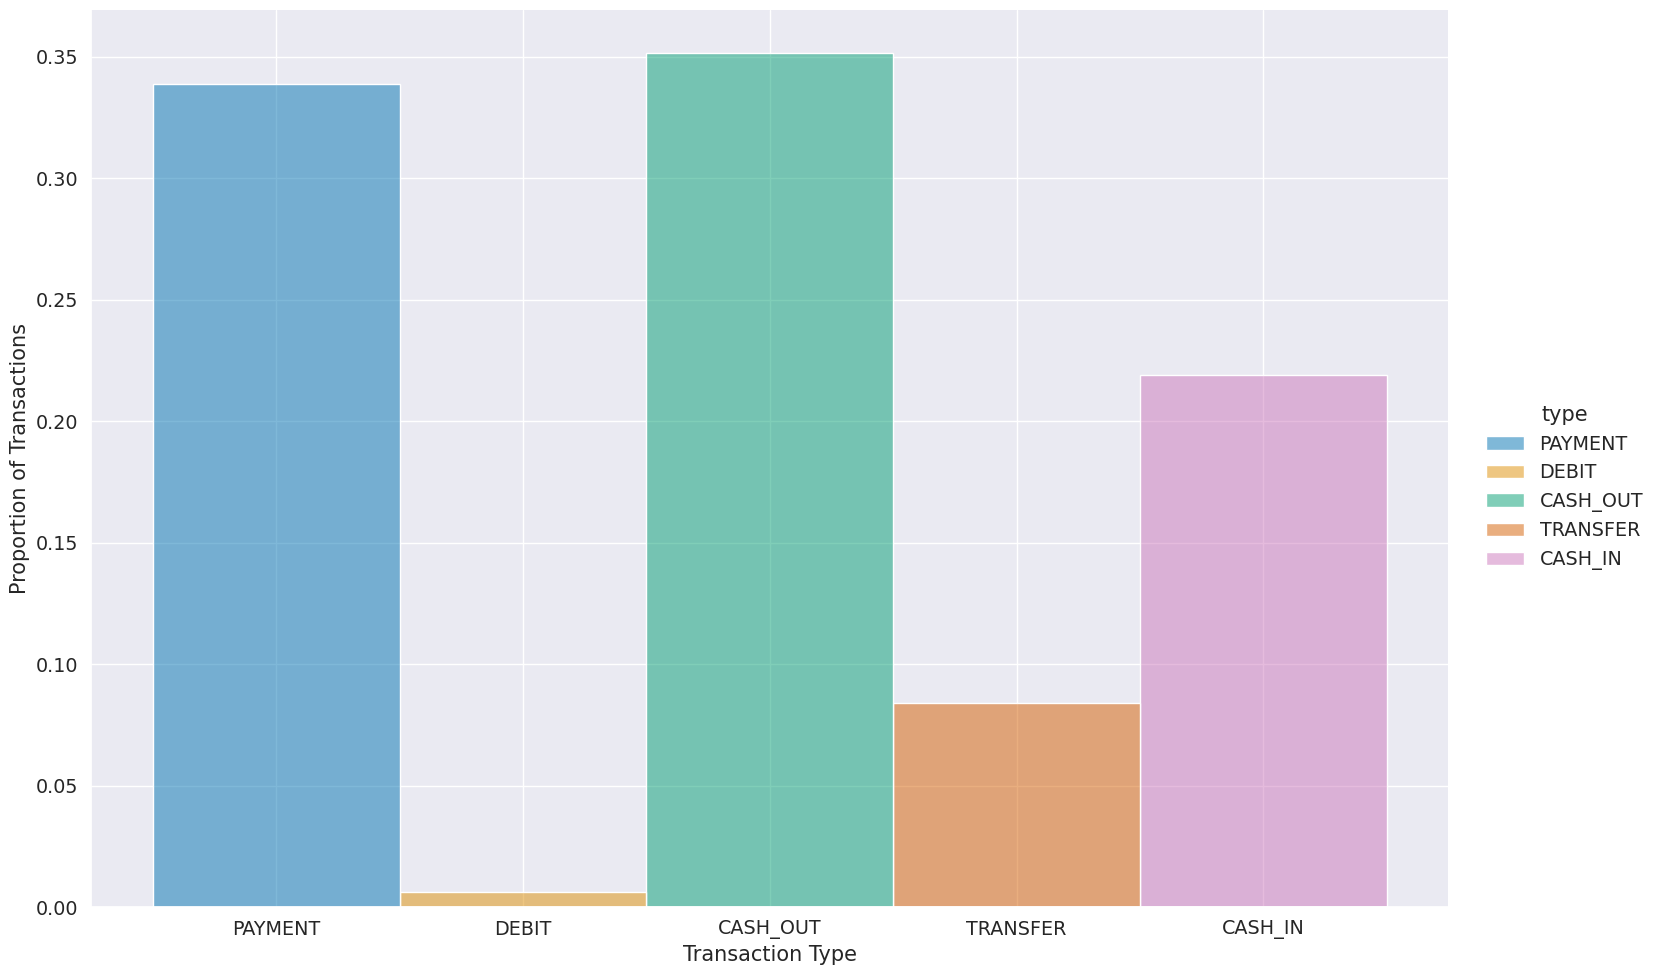

In [ ]:
fig = sns.displot(data=dfp, x='type', stat='probability'\
                  , height=10, aspect=1.5, palette = 'colorblind', hue='type')
fig.set_axis_labels('Transaction Type', 'Proportion of Transactions')

The Majority of the Transactions are PAYMENT (34%) and CASH_OUT(34%) transactions.

DEBIT transactions are by far the least (~1%).

Considering that, how does this distribution compare to the Fraudulent transaction types that occured?

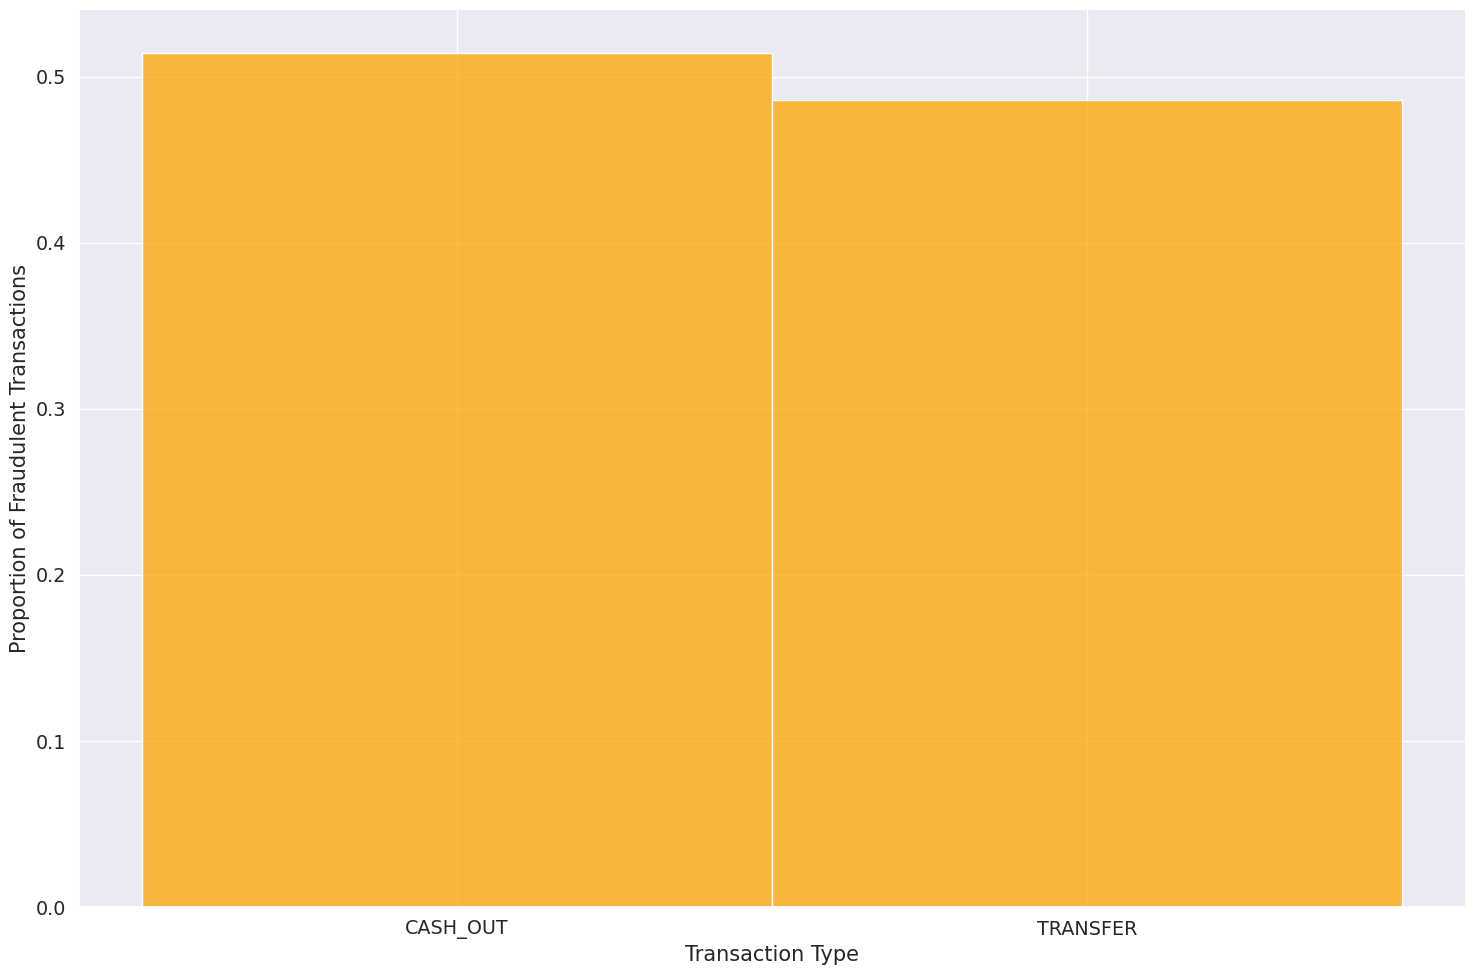

In [ ]:
fig = sns.displot(data=dfp[dfp['isFraud'] == 1],
                  x='type', stat='probability', height=10, aspect=1.5, color='orange')
fig.set_axis_labels('Transaction Type', 'Proportion of Fraudulent Transactions')

The _only_ Fraudulent transactions are _Transfer and Cash Out_, with roughly equal amounts of each being made.

With "type" being a categorical variable - I want to see some descriptive statistics around the value of the transactions.

I like to view **percentiles**, as it will also give a quick indication on whether or not there are any outliers present.

In [ ]:
# I perform this specifically using pyspark on the full dataframe,
# as I would like to get an idea of the complexity of doing it via pyspark

# Import functions as F to help calculate the percentiles
import pyspark.sql.functions as F
df1 = df.groupBy('type').agg( F.expr('percentile(amount, array(0.01))')[0].alias('%01'),
                        F.expr('percentile(amount, array(0.05))')[0].alias('%05'),
                        F.expr('percentile(amount, array(0.25))')[0].alias('%25'),
                        F.expr('percentile(amount, array(0.50))')[0].alias('%50'),
                        F.expr('percentile(amount, array(0.75))')[0].alias('%75'),
                        F.expr('percentile(amount, array(0.95))')[0].alias('%95'),
                        F.expr('percentile(amount, array(0.99))')[0].alias('%99'))
df1.limit(7).toPandas()

,type,%01,%05,%25,%50,%75,%95,%99
0,TRANSFER,"8,797.02","43,290.36","215,905.34","486,308.38","974,958.00","2,674,586.95","10,000,000.00"
1,CASH_IN,"2,999.74","14,552.34","70,510.18","143,427.71","239,899.09","412,005.12","550,870.85"
2,CASH_OUT,"3,108.00","15,266.73","72,669.65","147,072.19","246,539.48","427,877.16","579,654.09"
3,PAYMENT,176.19,871.69,"4,383.82","9,482.19","17,561.22","37,835.66","59,500.11"
4,DEBIT,68.53,324.67,"1,500.18","3,048.99","5,479.18","14,795.35","50,817.98"


From the above, I can see:

 * TRANSFER and CASH_OUT transactions had the highest _median_ and _Maximum_ transaction values.

* There appears to be **outlying** transaction amounts with all of the transaction types.  This is something I would normally deal with later on, should I want to use a model that is sensitive to outliers.

I would consider *capping* the outliers at the 95th or 99th percentile, or removing the outlying records completely, depending on whether they are found as part of a Fraudulent transaction.   

If the outliers are part of a Fraudulent transaction, I would consider adding a binary variable as well to indicate that it is an Outlying amount, along with capping the amount - this is due to the fact that it is outlying, might be relevant with regards to being Fraudulent

Considering 2 of the features I created (*txn_hour* and *merchInvolved*), how do they relate to the transaction being fraudulent?

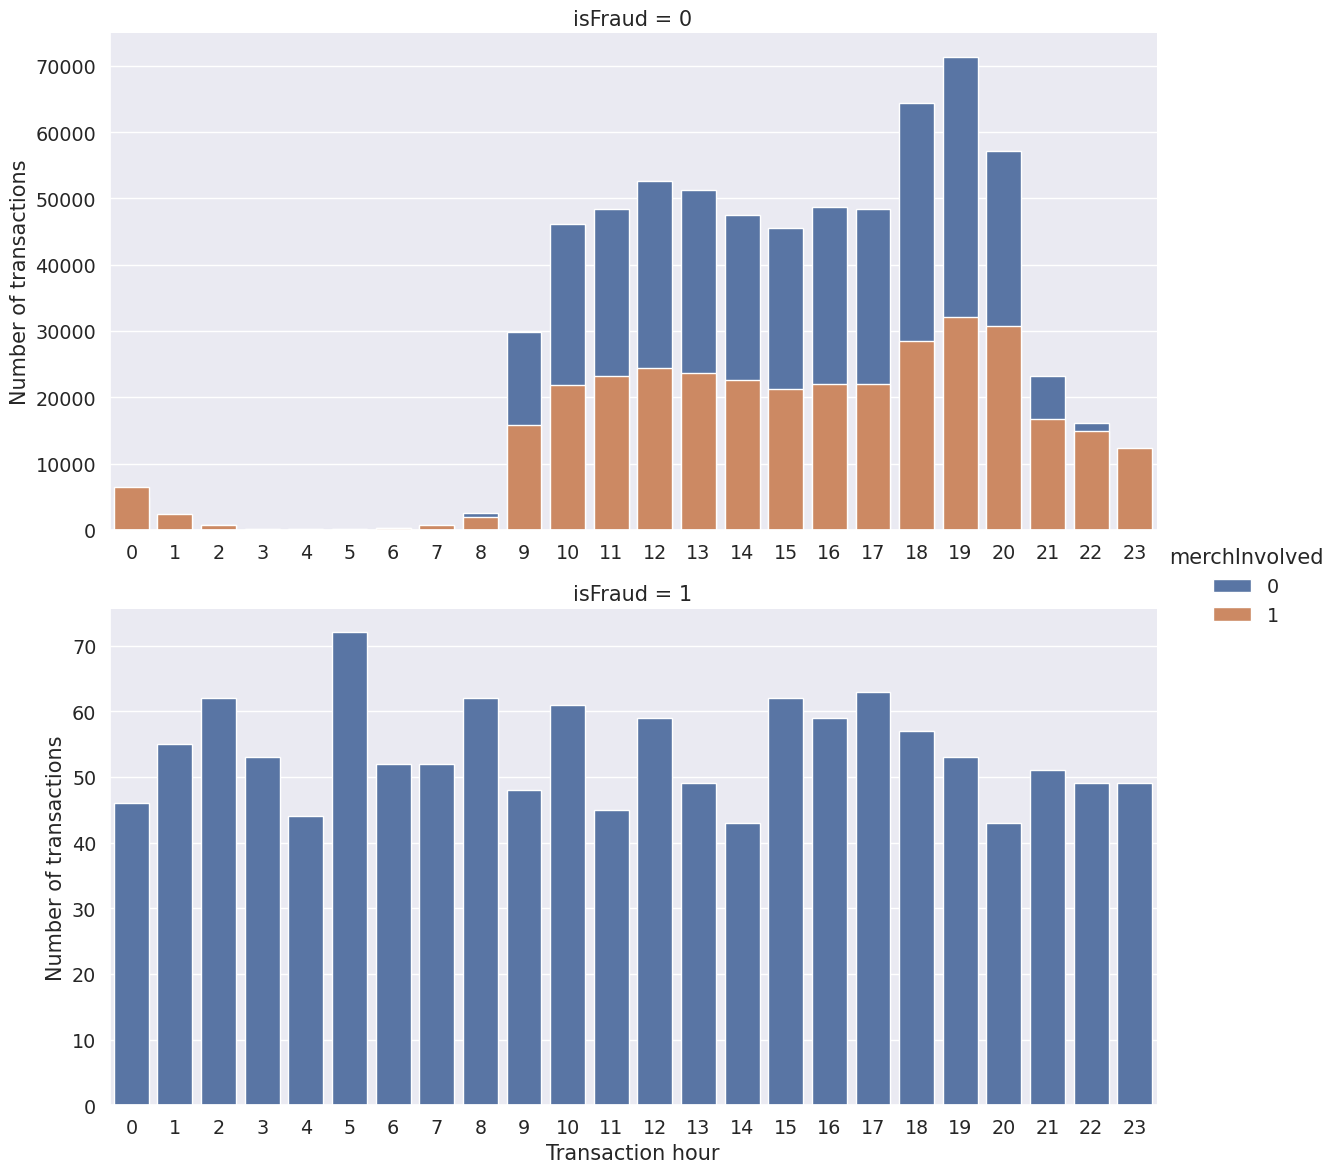

In [ ]:
ax = sns.catplot(kind='bar',
            data=dfp.groupby(['txn_hour', 'merchInvolved', 'isFraud'])
                        .size().reset_index()
           , x='txn_hour'
           , y = 0
           , row ='isFraud'
           , hue='merchInvolved'
           , dodge=False
           , height=6
           , aspect=2
           , sharey=False
           ,sharex=False)
ax.set_xlabels('Transaction hour', fontsize=15 )
ax.set_ylabels('Number of transactions', fontsize=15 )

Between 09:00 and 20:00, there are more transactions that do not involve a merchant, other times merchant transactions start picking up.

_None of the Fraudulent transactions had a Merchant involved in them, which makes sense as merchants would likely not commit fraud directly on their clients_

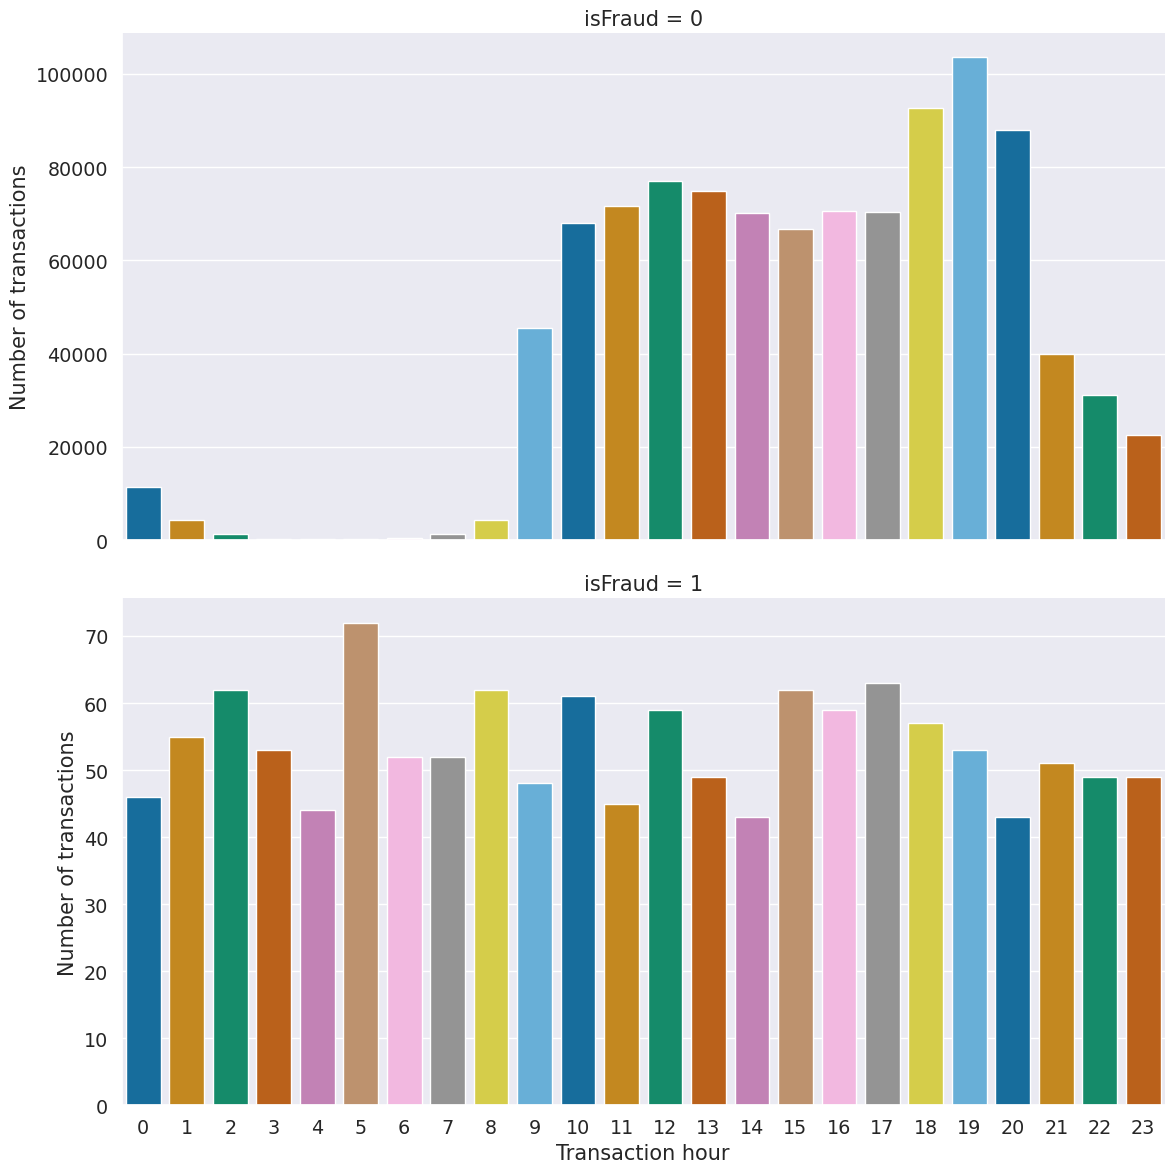

In [ ]:
hour_vs_fraud = sns.catplot(  kind  ='count'
            , x     ="txn_hour"
            , row   ='isFraud'
            , data  =dfp
            , sharey=False
            , height=6
            , aspect=2
            , hue = "txn_hour"
            , legend= False
            , palette = 'colorblind'
           )
hour_vs_fraud.set_xlabels('Transaction hour')
hour_vs_fraud.set_ylabels('Number of transactions')

plt.show()

The majority of transactions happen between 09:00 and 19:00 during the day. With some of them after hours.

Fraudulent transactions are _relatively evenly_ distributed across the day, with no clear peak value.

What does the average transaction amount look like per hour?

Text(0, 0.5, 'Avg. transaction amount')

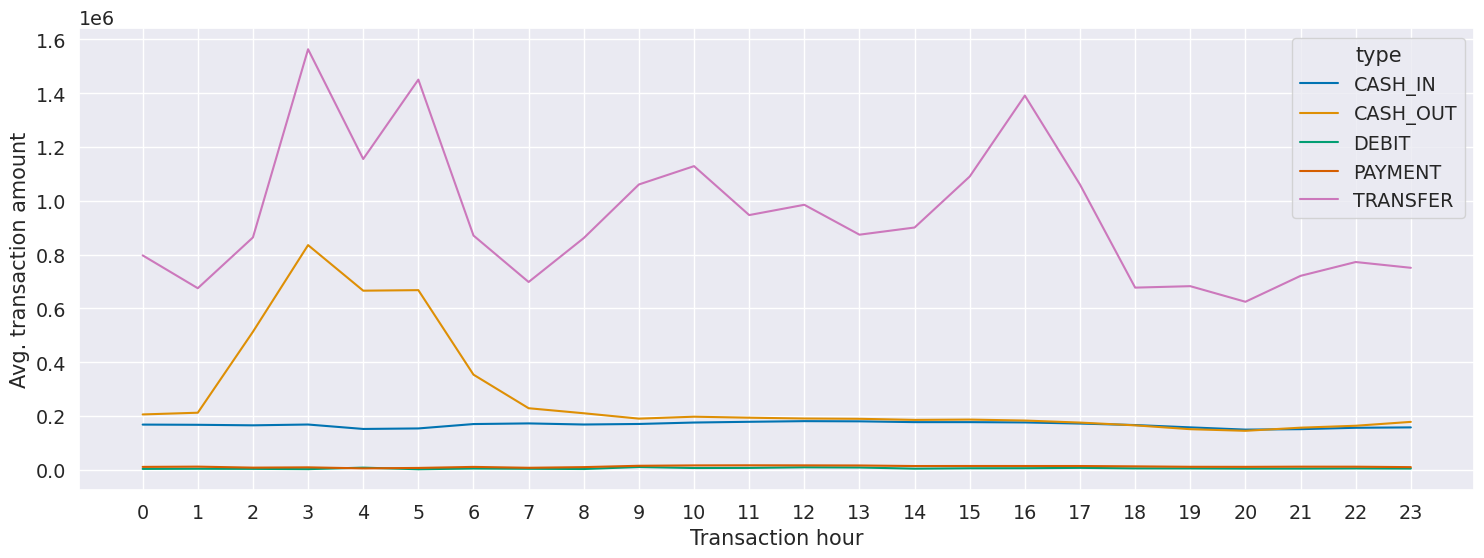

In [ ]:
# Need to get the average amount per hour and plot that,
# per transaction type and split for fraud vs non-fraud
plt.figure(figsize=(18,6))
sns.lineplot(data=dfp.groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type',
             palette='colorblind'
           )
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

It is a bit hard to see the values for CASH_IN, DEBIT and PAYMENT, due to them being so small compared to the rest, so  I split them out and plot seperately.

Text(0, 0.5, 'Avg. transaction amount')

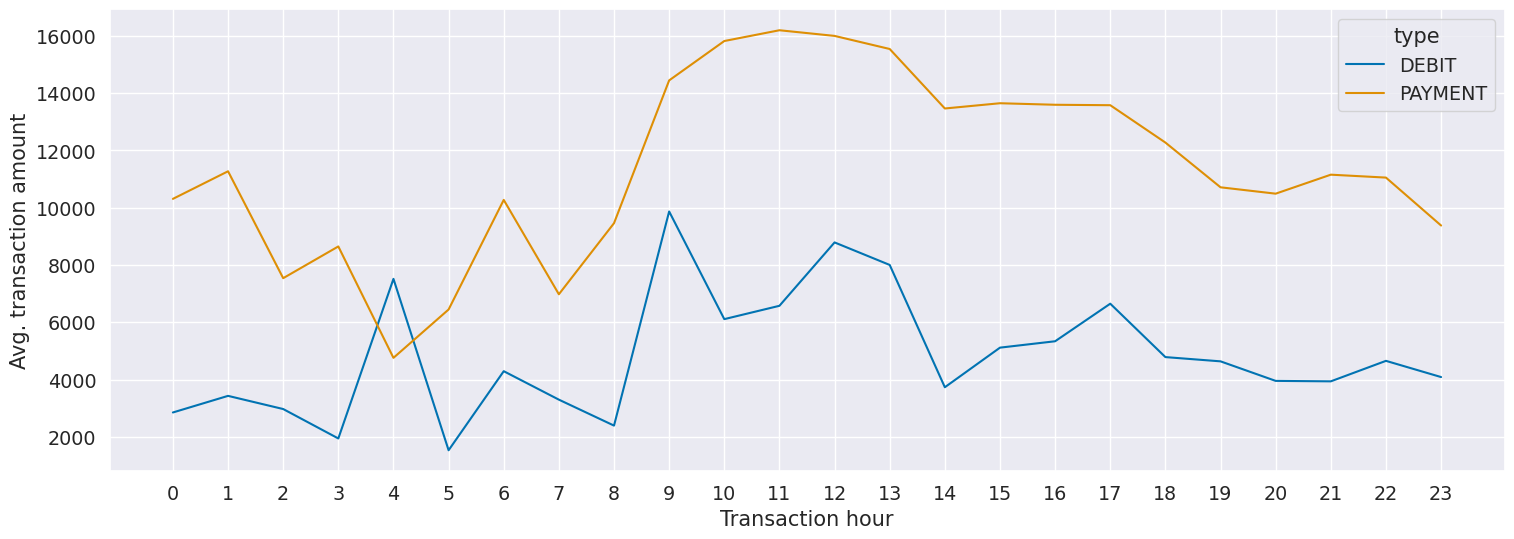

In [ ]:
# Check for the ones we couldnt make out in the above graph
plt.figure(figsize=(18,6))
sns.lineplot(data=dfp[dfp['type']
                        .isin(['DEBIT','PAYMENT'])]
                 .groupby(['txn_hour','type'])
                 .agg({'amount' : 'mean'})
                 .reset_index(),
             x='txn_hour',
             y='amount',
             hue='type',
             palette='colorblind')
plt.xlabel('Transaction hour', fontsize=15 )
plt.xticks(range(24), range(24))
plt.ylabel('Avg. transaction amount', fontsize=15)

* CASH OUTS tend to happen early morning (between 03:00 and 05:00), while TRANSFERS peak very early morning (03:00), and again at 16:00

* DEBITS and PAYMENTS peak between 09:00 and 13:00 during the day

What about the parties involved in the transactions? Is there a difference in times throughout the day?

Lets look at the distribution of the various balances for both origination and destination accounts.

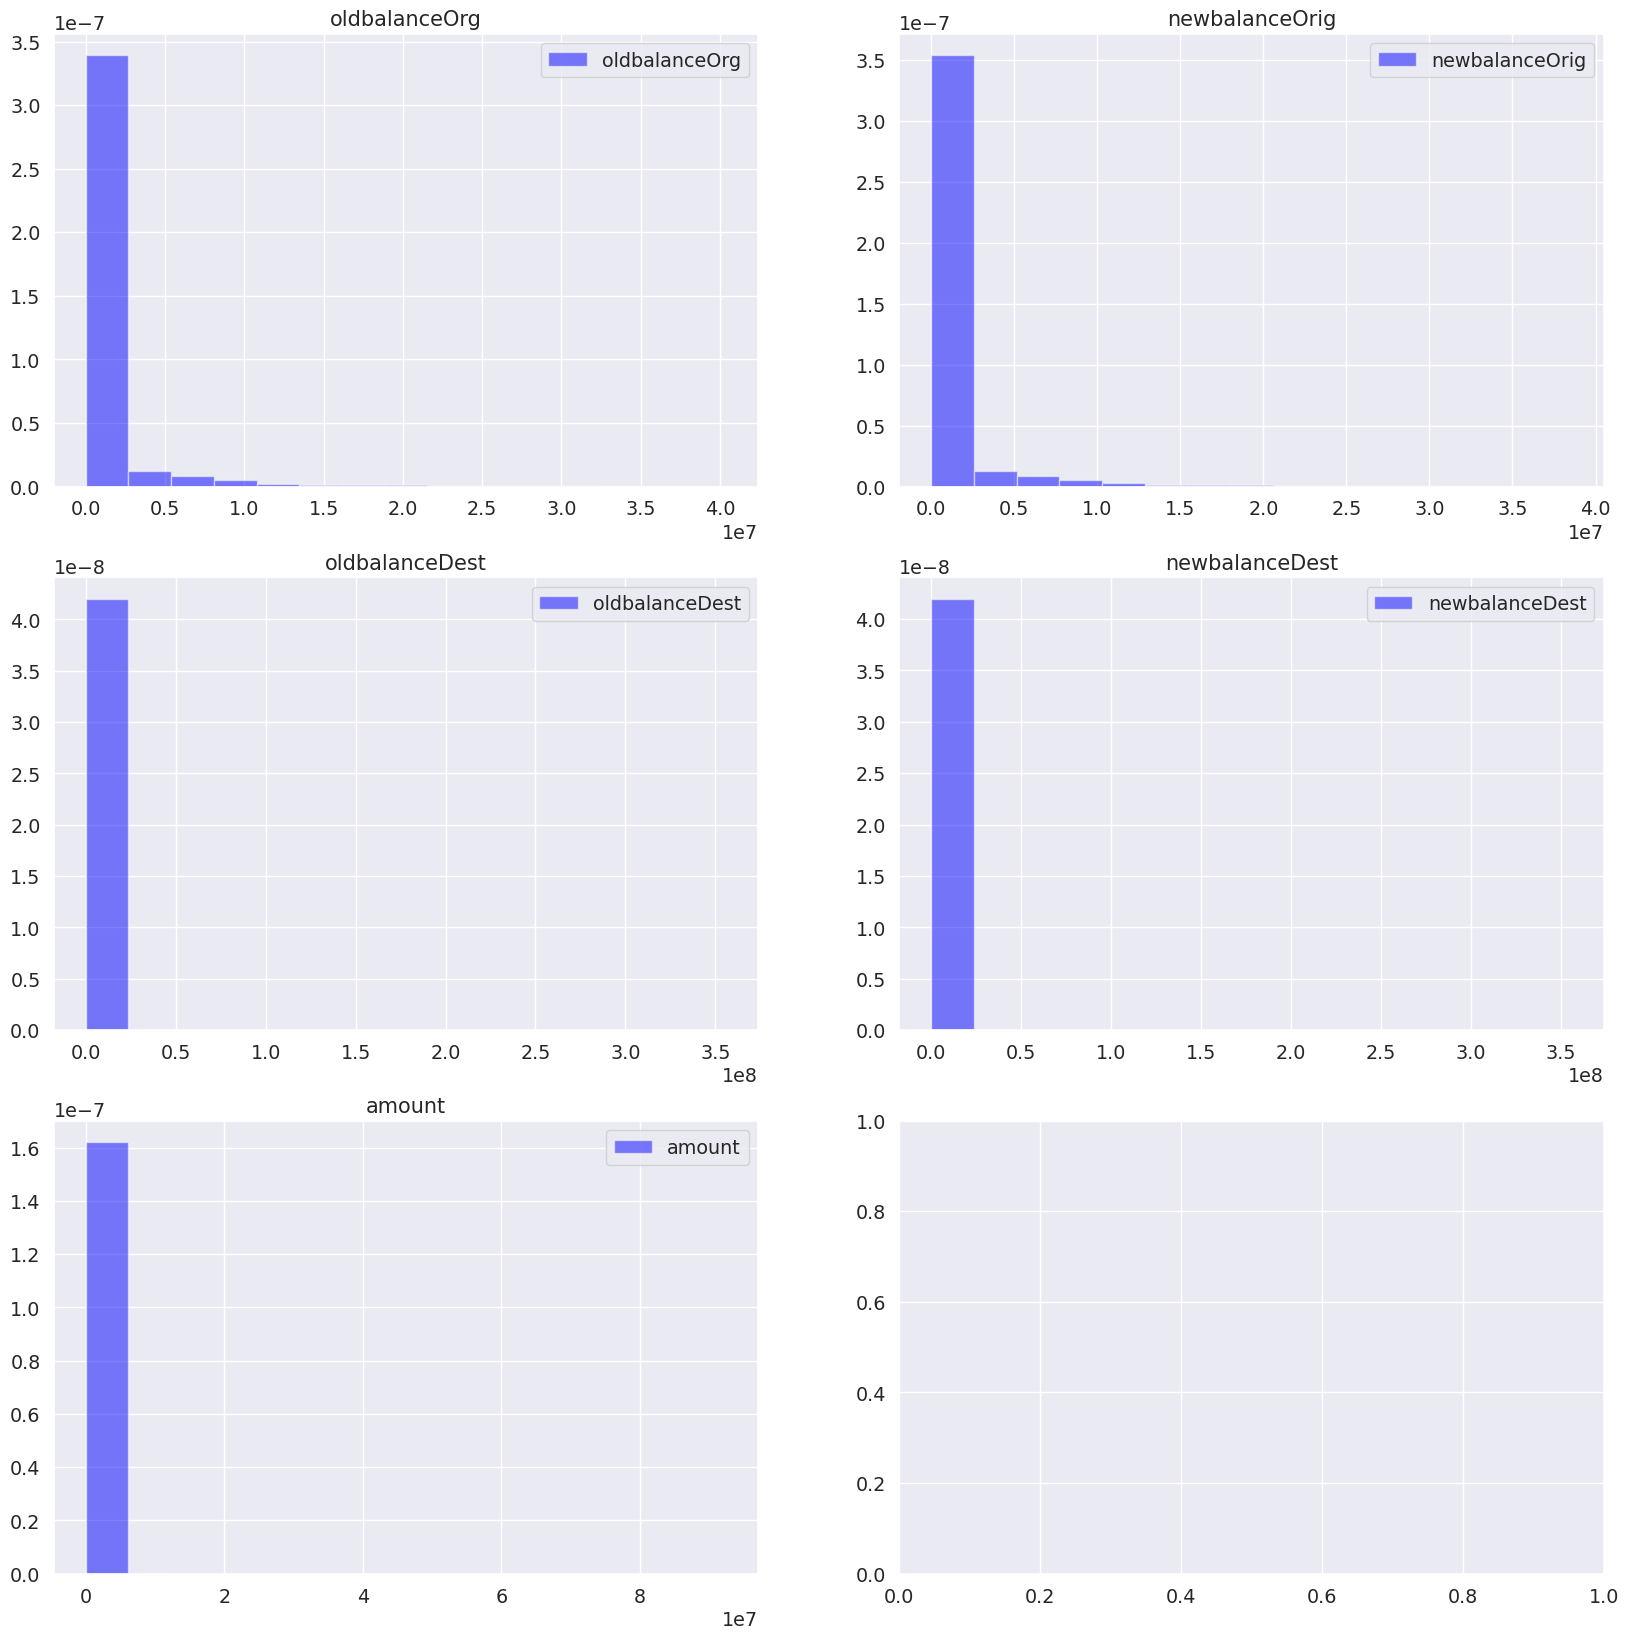

In [ ]:
bins=15
fig, axs = plt.subplots(3,2,figsize=(20, 20), sharey = False)

axs[0, 0].hist(dfp['oldbalanceOrg'], bins=bins, color='blue', alpha=0.5, label='oldbalanceOrg', density=True)
axs[0, 0].set_title('oldbalanceOrg')
axs[0, 0].legend()

axs[0, 1].hist(dfp['newbalanceOrig'], bins=bins, color='blue',
               alpha=0.5, label='newbalanceOrig', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist(dfp['oldbalanceDest'], bins=bins, color='blue', alpha=0.5, label='oldbalanceDest', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist(dfp['newbalanceDest'], bins=bins, color='blue', alpha=0.5, label='newbalanceDest', density=True)
axs[1, 1].set_title('newbalanceDest')
axs[1, 1].legend()

axs[2, 0].hist(dfp['amount'], bins=bins, color='blue', alpha=0.5, label='amount', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()

* Most of these data points are _very skewed_ as we saw before when looking at the statistics.

It might be better to display the data without the massive skewness I see in there, so I am applying a _log transformation_ on everything I plot.

The data is also split for fraud vs non-fraud transactions to see if there are differences in the distributions between the 2 sets.

In [ ]:
# Create a fraud dataframe and a non-fraud dataframe
dfp_fraud    = dfp[dfp['isFraud'] == 1]
dfp_nonfraud = dfp[dfp['isFraud'] == 0]

dfp_nonfraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour
0,1,PAYMENT,"4,098.78",C1026483832,"503,264.00","499,165.22",M1635378213,0.00,0.00,0,0,0,1,1,1
1,1,PAYMENT,"3,448.92",C2103763750,0.00,0.00,M335107734,0.00,0.00,0,0,0,1,1,1
2,1,PAYMENT,"24,213.67",C1238616099,0.00,0.00,M70695990,0.00,0.00,0,0,0,1,1,1
3,1,PAYMENT,"2,791.42",C923341586,"300,481.00","297,689.59",M107994825,0.00,0.00,0,0,0,1,1,1
4,1,PAYMENT,"7,413.54",C1470868839,"297,689.59","290,276.03",M1426725223,0.00,0.00,0,0,0,1,1,1


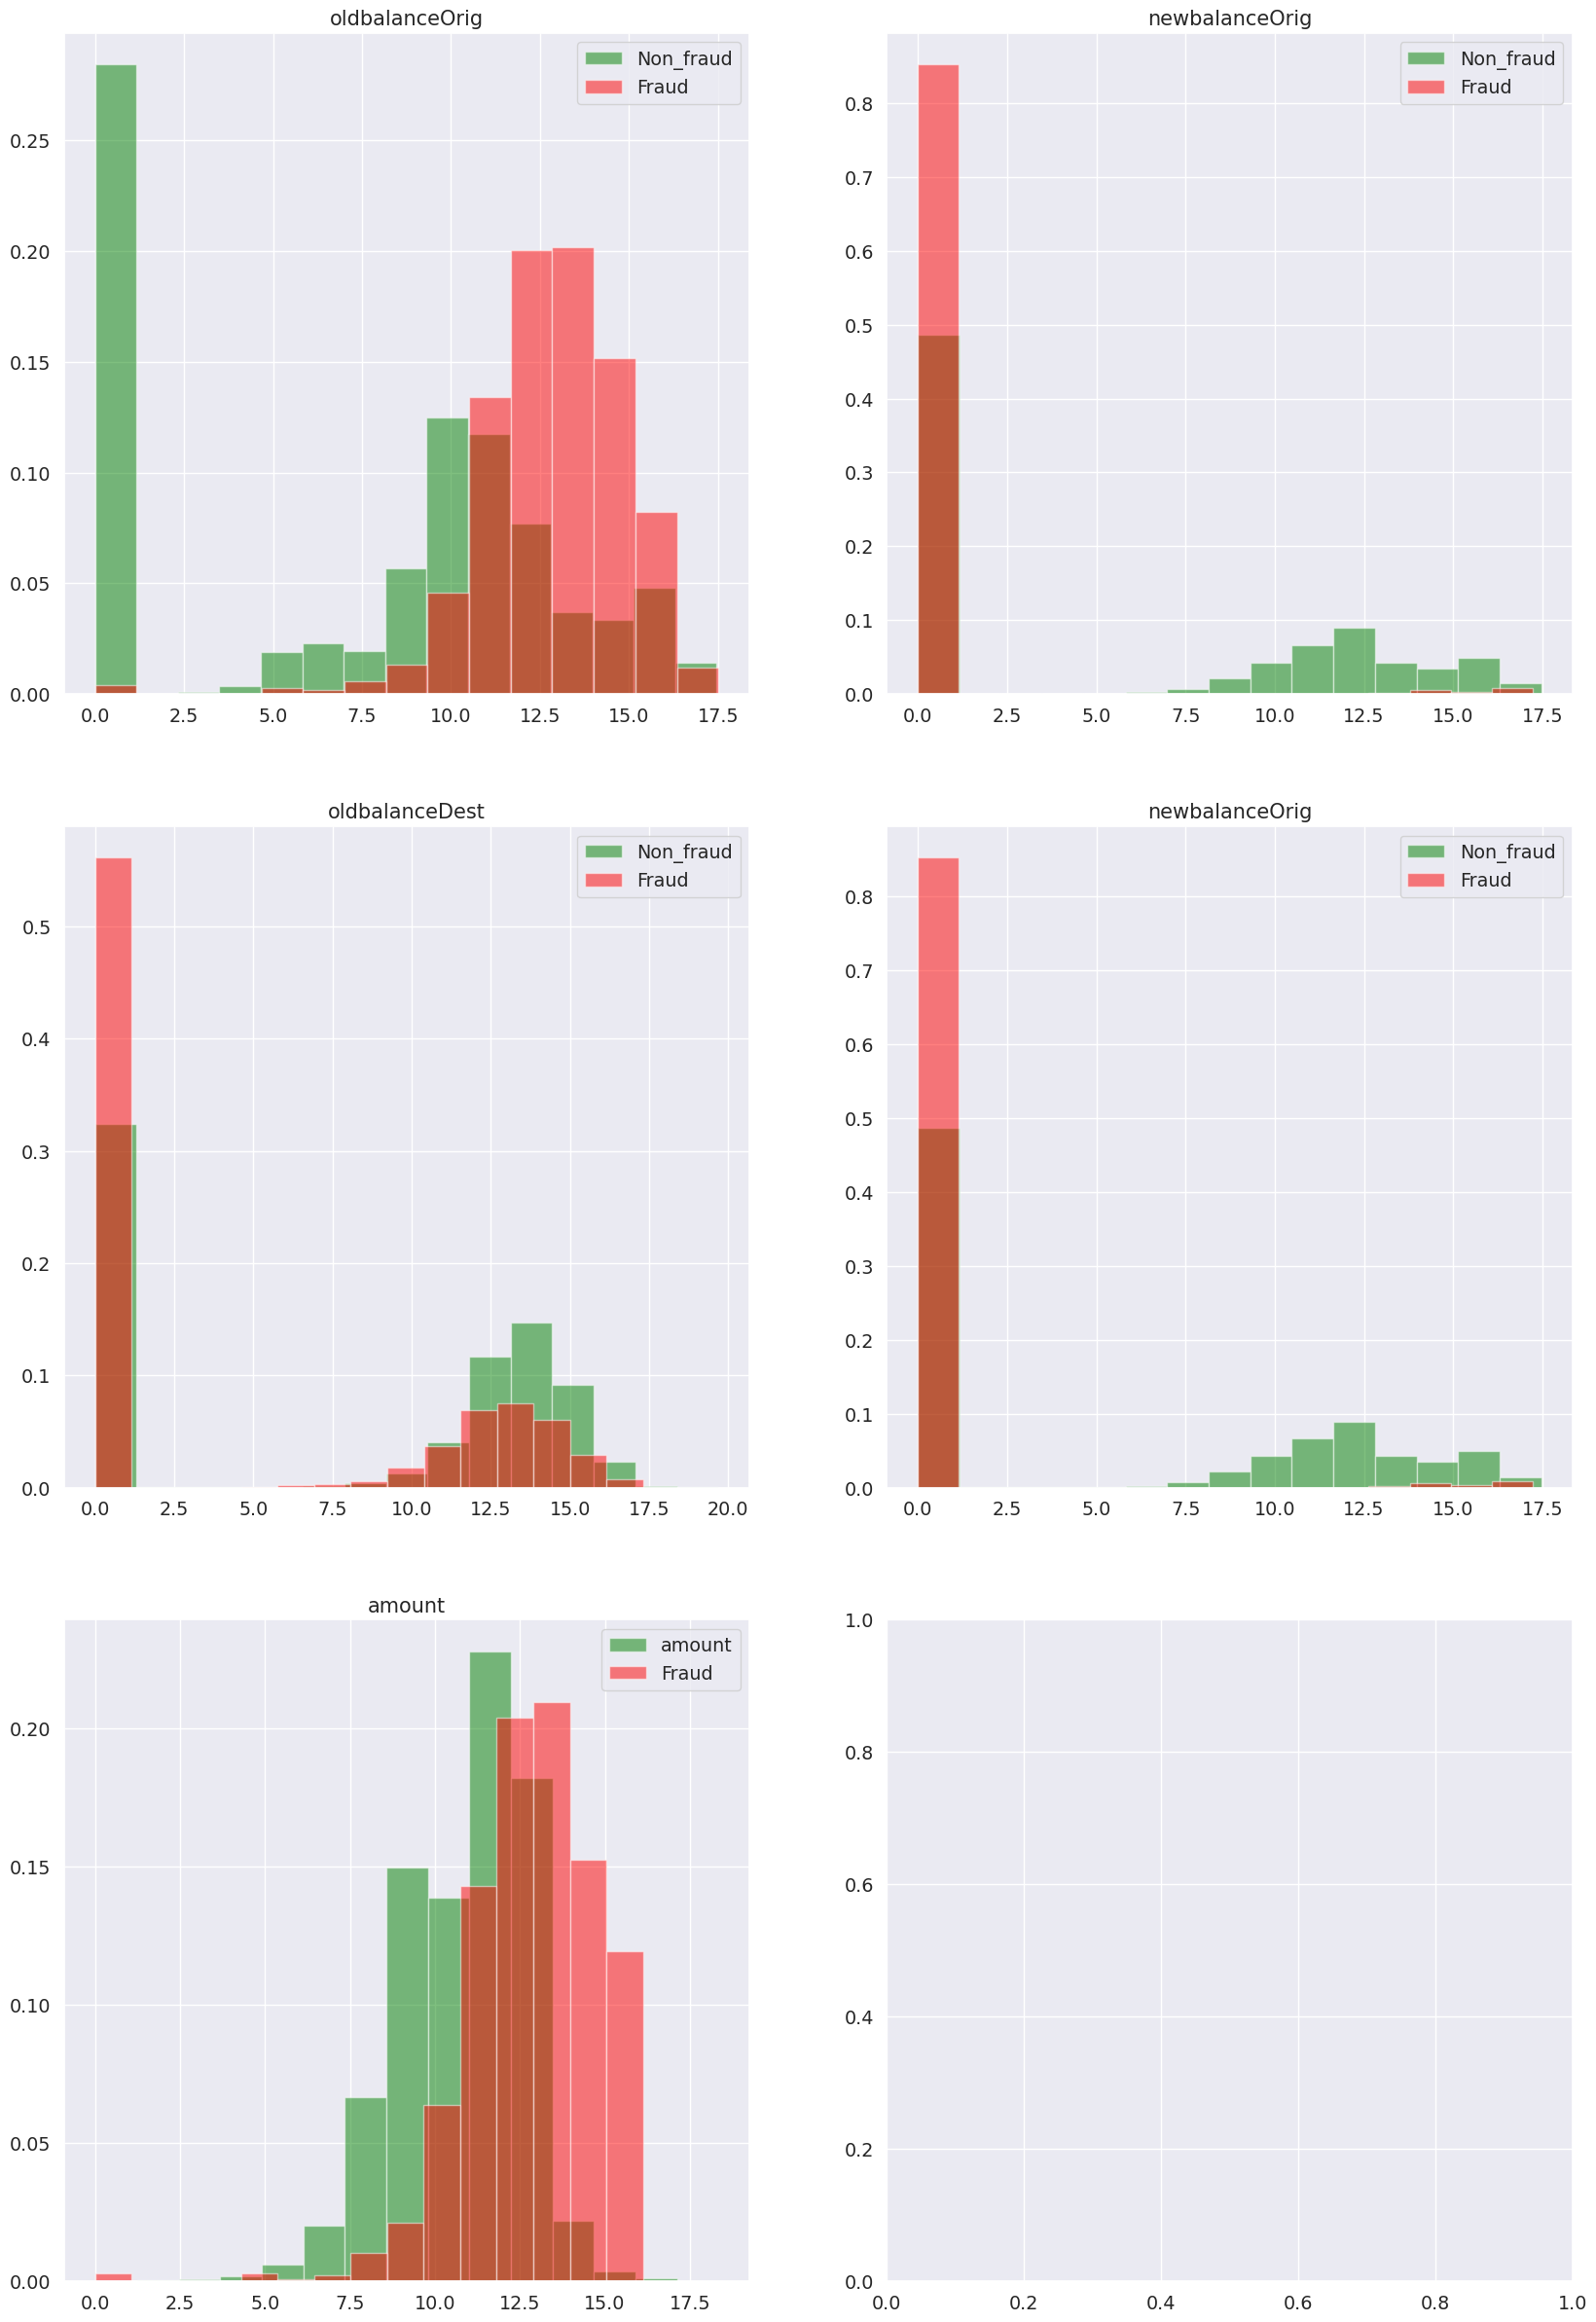

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

axs[0, 0].hist((dfp_nonfraud['oldbalanceOrg'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 0].hist((dfp_fraud['oldbalanceOrg'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 0].set_title('oldbalanceOrig')
axs[0, 0].legend()

axs[0, 1].hist((dfp_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 1].hist((dfp_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 1].set_title('newbalanceOrig')
axs[0, 1].legend()

axs[1, 0].hist((dfp_nonfraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 0].hist((dfp_fraud['oldbalanceDest'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 0].set_title('oldbalanceDest')
axs[1, 0].legend()

axs[1, 1].hist((dfp_nonfraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 1].hist((dfp_fraud['newbalanceOrig'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 1].set_title('newbalanceOrig')
axs[1, 1].legend()

axs[2, 0].hist((dfp_nonfraud['amount'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='amount', density=True)
axs[2, 0].hist((dfp_fraud['amount'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 0].set_title('amount')
axs[2, 0].legend()

* Amounts are skewed to the right for fraudulent transactions - _fraudulent transactions appear to be of higher value_.

* There are a lot of accounts that had a _0 balance AFTER the transaction occurred_, which indicates that fraudulent transactions tend to clear out the accounts.  A feature capturing this could be valuable, however - the balance features should not be used as per the dataset metadata (however, this is only dubious for transactions that WERE detected as fraud)

Something to examine, would be whether customers have multiple transactions in the data?

Due to it being simulated, it might not be.

In [ ]:
# How many unique originating and destination names are there?
# Dataframe dimensions to recap the observation count
print(f"This dataframe has {df.count()} rows. \n")

df.select(countDistinct('nameOrig')).show()
df.select(countDistinct('nameDest')).show()

This dataframe has 6362620 rows. 

+------------------------+
|count(DISTINCT nameOrig)|
+------------------------+
|                 6353307|
+------------------------+

+------------------------+
|count(DISTINCT nameDest)|
+------------------------+
|                 2722362|
+------------------------+



* There appear to be _multiple transactions_ per originating and destination client/merchant.  

Meaning features on what happened PRIOR to a transaction happening for each client can be created.

In [ ]:
# How many transactions were there, where there are multiple?
# create a temporary view to query using spark sql
df.createOrReplaceTempView("df2")
spark.sql('select nameOrig,isFraud, count(1) as NUM_TRANS from df2 group by nameOrig, isFraud order by num_trans desc').show(10)
spark.sql('select nameDest,isFraud, count(1) as NUM_TRANS from df2 group by nameDest, isFraud order by num_trans desc').show(10)


+-----------+-------+---------+
|   nameOrig|isFraud|NUM_TRANS|
+-----------+-------+---------+
|C1999539787|      0|        3|
|C2051359467|      0|        3|
|C1976208114|      0|        3|
|C1677795071|      0|        3|
|C1902386530|      0|        3|
| C545315117|      0|        3|
| C724452879|      0|        3|
| C400299098|      0|        3|
|C1462946854|      0|        3|
|C1832548028|      0|        3|
+-----------+-------+---------+
only showing top 10 rows

+-----------+-------+---------+
|   nameDest|isFraud|NUM_TRANS|
+-----------+-------+---------+
|C1286084959|      0|      113|
| C985934102|      0|      109|
| C665576141|      0|      105|
|C2083562754|      0|      102|
| C248609774|      0|      101|
|C1590550415|      0|      101|
|C1789550256|      0|       99|
| C451111351|      0|       99|
|C1360767589|      0|       98|
|C1023714065|      0|       97|
+-----------+-------+---------+
only showing top 10 rows



* There are definitely clients that had multiple transactions in the data, so _creating features to characterise their behaviour prior to a new transaction, could prove valuable_.

What about fraudulent transactions - are there clients that had multiple linked to them?

In [ ]:
# How many transactions were there, where there are multiple?
spark.sql('select nameOrig, count(1) as NUM_TRANS from df2 where isFraud = 1 group by nameOrig order by num_trans desc').show(10)
spark.sql('select nameDest, count(1) as NUM_TRANS from df2 where isFraud = 1 group by nameDest order by num_trans desc').show(10)


+-----------+---------+
|   nameOrig|NUM_TRANS|
+-----------+---------+
|C2079232448|        1|
| C439464764|        1|
| C281192595|        1|
|C1584512618|        1|
|C1683055902|        1|
|C1544211314|        1|
| C921148283|        1|
| C938980312|        1|
|C1894578299|        1|
|C1422357582|        1|
+-----------+---------+
only showing top 10 rows

+-----------+---------+
|   nameDest|NUM_TRANS|
+-----------+---------+
| C200064275|        2|
|  C52390890|        2|
|C1827219533|        2|
| C410033330|        2|
| C935310781|        2|
| C104038589|        2|
| C185805228|        2|
| C904300960|        2|
| C803116137|        2|
|C1013511446|        2|
+-----------+---------+
only showing top 10 rows



* There are instances of Destination clients that had multiple fraudulent transactions linked to them.  


*A business rule one could add to prevent fraudulent transactions in future, could be to perform enhanced due diligence, if funds are transferred to a nameDest, that was previously involved in fraudulent transactions.*

In [ ]:
# Drop the temp view I used to query, to free up resources
spark.catalog.dropTempView("df2")

True



---



# **Feature Engineering**

Create an indicator variable to show whether the original balance has been cleared out (all funds were transferred out of the account), identified during the initial EDA.

In [ ]:
df = df.withColumn('origBalanceCleared', (col('newbalanceOrig') == 0).cast(IntegerType()) )

Now identify clients' behaviour BEFORE a particular transaction, and whether the client was involved in a fraudulent transaction before.

In [ ]:
# create tables that summarise the features for the originating party and the destination party respectively
a = df.alias("a")
b = df.alias("b")

# Create a dataset to use that I can derive features for, for the Originating party in the transaction
orig_features = a.join(b,a.nameOrig == b.nameOrig  , how='left'). \
                select(col("a.nameOrig").alias("orig_nameOrig"), "a.step", col("b.step").alias("PREV_STEP"), \
                       "b.amount", "b.isFraud", "b.txn_hour", "b.merchInvolved", \
                       "b.merchOrig", "b.merchDest").where("PREV_STEP < step")

# Create a dataset to use that I can derive features for, for the Destination party in the transaction
dest_features = a.join(b,a.nameDest == b.nameDest  , how='left'). \
                select(col("a.nameDest").alias('dest_nameDest'), "a.step", col("b.step").alias("PREV_STEP"), \
                       "b.amount", "b.isFraud", "b.txn_hour", "b.merchInvolved", \
                       "b.merchOrig", "b.merchDest").where("PREV_STEP < step")


In [ ]:
#Check whether it had the desired effect and summarisation I expected, this also triggers the creation of the dataset
orig_features.show(5)
dest_features.show(5)

+-------------+----+---------+---------------+-------+--------+-------------+---------+---------+
|orig_nameOrig|step|PREV_STEP|         amount|isFraud|txn_hour|merchInvolved|merchOrig|merchDest|
+-------------+----+---------+---------------+-------+--------+-------------+---------+---------+
|   C100025963| 277|      254|21813.130859375|      0|      14|            0|        0|        0|
|  C1001064466| 469|      138| 49421.26171875|      0|      18|            0|        0|        0|
|  C1005646800| 184|       21|   156163.46875|      0|      21|            0|        0|        0|
|  C1005754324| 596|      299| 59789.19921875|      0|      11|            0|        0|        0|
|  C1006478345| 356|      229|16432.279296875|      0|      13|            1|        0|        1|
+-------------+----+---------+---------------+-------+--------+-------------+---------+---------+
only showing top 5 rows

+-------------+----+---------+-------------+-------+--------+-------------+---------+--------

Examining the data results, it had the effect I wanted, as the table joined to itself, where the current transaction step is smaller than the previous one.

Note that not all clients will have features here, depending on if they transacted before, or not.

I now want to group the features for the destination and the origination features to create the various behavioural features.

I am interested in:

    1. How many merchants that party has transacted with previously (sum(merchInvolved)
    2. How many transactions they made previously (count(PREV_STEP))
    3. What is the average transaction amount they have made previously (avg(amount))
    4. What the average time is that transactions are usually made for them (avg(txn_hour))
    5. Whether they have been involved in Fraud before (max(isFraud))
    6. How many times they have been involved with transactions with Merchants (sum(merchInvolved))
    7. How many times transactions were conducted where a merchant was the orginating or destination party (sum(merchOrig), sum(merchDest))

In [ ]:
orig_features = orig_features.groupby('orig_nameOrig', 'step').agg({"PREV_STEP": "count", "amount" :"mean", "isFraud" :"max", \
                                              "txn_hour": "mean", "merchInvolved" : "sum", \
                                              "merchOrig" : "sum", "merchDest":"sum"}) \
                                            .withColumnRenamed("step", "orig_step")\
                                            .withColumnRenamed("sum(merchInvolved)", "prev_orig_merchInvolved_total")\
                                            .withColumnRenamed("max(isFraud)"      , "prev_orig_fraud_max")\
                                            .withColumnRenamed("avg(txn_hour)"     , "prev_orig_txn_hour_avg")\
                                            .withColumnRenamed("sum(merchDest)"    , "prev_orig_merchDest_sum")\
                                            .withColumnRenamed("avg(amount)"       , "prev_orig_avg_amount")\
                                            .withColumnRenamed("count(PREV_STEP)"  , "prev_orig_steps_num")\
                                            .withColumnRenamed("sum(merchOrig)"    , "prev_orig_merch_orig_sum")



dest_features = dest_features.groupby('dest_nameDest', 'step').agg({"PREV_STEP": "count", "amount" :"mean", "isFraud" :"max", \
                                              "txn_hour": "mean", "merchInvolved" : "sum", \
                                              "merchOrig" : "sum", "merchDest":"sum"}) \
                                            .withColumnRenamed("step", "dest_step")\
                                            .withColumnRenamed("sum(merchInvolved)", "prev_dest_merchInvolved_total")\
                                            .withColumnRenamed("max(isFraud)"      , "prev_dest_fraud_max")\
                                            .withColumnRenamed("avg(txn_hour)"     , "prev_dest_txn_hour_avg")\
                                            .withColumnRenamed("sum(merchDest)"    , "prev_dest_merchDest_sum")\
                                            .withColumnRenamed("avg(amount)"       , "prev_dest_avg_amount")\
                                            .withColumnRenamed("count(PREV_STEP)"  , "prev_dest_steps_num")\
                                            .withColumnRenamed("sum(merchOrig)"    , "prev_dest_merch_orig_sum")





In [ ]:
# View the dataset in Pandas, also force spark to execute and create the views
orig_features.limit(5).toPandas()
dest_features.limit(5).toPandas()

,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,C1000030947,37,0,0,10.00,0,"124,587.08",1,0
1,C1000030947,41,0,0,11.50,0,"263,175.87",2,0
2,C1000030947,130,0,0,13.33,0,"278,956.36",3,0
3,C1000030947,134,0,0,12.50,0,"229,274.46",4,0
4,C1000030947,136,0,0,12.80,0,"198,257.36",5,0


In [ ]:
# join everything together into one dataframe and seeing how it joined, and if it joined correctly
df=df.join(orig_features, (df.nameOrig == orig_features.orig_nameOrig) \
        & (df.step == orig_features.orig_step), how='left')\
        .join(dest_features, (df.nameDest == dest_features.dest_nameDest) \
        & (df.step == dest_features.dest_step), how='left')
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,297,CASH_OUT,"117,896.80",C1130335347,0.00,0.00,C1864208892,"165,736.88","283,633.69",0,0,0,0,0,9,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1864208892,297.00,0.00,0.00,15.68,0.00,"158,620.02",19.00,0.00
1,40,PAYMENT,"16,435.99",C1239058320,0.00,0.00,M1315303460,0.00,0.00,0,0,0,1,1,16,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,239,TRANSFER,"343,347.44",C1279385291,0.00,0.00,C1089091448,"751,129.00","1,094,476.38",0,0,0,0,0,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1089091448,239.00,0.00,0.00,16.50,0.00,"329,474.05",2.00,0.00
4,335,PAYMENT,"14,616.95",C1164405625,0.00,0.00,M1877556814,0.00,0.00,0,0,0,1,1,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Remove tables I used in the query, to free up resources
orig_features.unpersist()
dest_features.unpersist()

DataFrame[dest_nameDest: string, dest_step: bigint, prev_dest_merchInvolved_total: bigint, prev_dest_fraud_max: bigint, prev_dest_txn_hour_avg: double, prev_dest_merchDest_sum: bigint, prev_dest_avg_amount: double, prev_dest_steps_num: bigint, prev_dest_merch_orig_sum: bigint]

In [ ]:
# Have a look at the schema of the dataframe to view all the columns added and their data types
df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)
 |-- merchOrig: integer (nullable = true)
 |-- merchDest: integer (nullable = true)
 |-- merchInvolved: integer (nullable = true)
 |-- txn_hour: long (nullable = true)
 |-- origBalanceCleared: integer (nullable = true)
 |-- orig_nameOrig: string (nullable = true)
 |-- orig_step: long (nullable = true)
 |-- prev_orig_merchInvolved_total: long (nullable = true)
 |-- prev_orig_fraud_max: long (nullable = true)
 |-- prev_orig_txn_hour_avg: double (nullable = true)
 |-- prev_orig_merchDest_sum: long (nullable = true)
 |-- prev_orig_avg_amount

In [ ]:
df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum
0,297,CASH_OUT,"117,896.80",C1130335347,0.00,0.00,C1864208892,"165,736.88","283,633.69",0,0,0,0,0,9,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1864208892,297.00,0.00,0.00,15.68,0.00,"158,620.02",19.00,0.00
1,40,PAYMENT,"16,435.99",C1239058320,0.00,0.00,M1315303460,0.00,0.00,0,0,0,1,1,16,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,239,TRANSFER,"343,347.44",C1279385291,0.00,0.00,C1089091448,"751,129.00","1,094,476.38",0,0,0,0,0,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1089091448,239.00,0.00,0.00,16.50,0.00,"329,474.05",2.00,0.00
4,335,PAYMENT,"14,616.95",C1164405625,0.00,0.00,M1877556814,0.00,0.00,0,0,0,1,1,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Owing to the _skewness_ of some of the data, applying a LOG transformation to the numeric columns plotted before could resolve this. To deal with the skewness and create the new features I actually want to model on (although my aim is not to use any modeling techniques that will be significantly influenced by the skewness of the data).

Since some variables have a 0 in them, I take the log + 1 of everything as the log of 0 does not exist.

In [ ]:
df =df.withColumn('log_oldbalanceOrg'  , log(col('oldbalanceOrg')+1 )) \
      .withColumn('log_newbalanceOrig' , log(col('newbalanceOrig')+1 )) \
      .withColumn('log_oldbalanceDest' , log(col('oldbalanceDest')+1 ))  \
      .withColumn('log_newbalanceDest' , log(col('newbalanceDest') +1 ))  \
      .withColumn('log_amount'         , log(col('amount')+1 ))\
      .withColumn('log_prev_orig_avg_amount'         , log(col('prev_orig_avg_amount')+1 )) \
      .withColumn('log_prev_dest_avg_amount'         , log(col('prev_dest_avg_amount')+1 ))

df.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount
0,297,CASH_OUT,"117,896.80",C1130335347,0.00,0.00,C1864208892,"165,736.88","283,633.69",0,0,0,0,0,9,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1864208892,297.00,0.00,0.00,15.68,0.00,"158,620.02",19.00,0.00,0.00,0.00,12.02,12.56,11.68,NaN,11.97
1,40,PAYMENT,"16,435.99",C1239058320,0.00,0.00,M1315303460,0.00,0.00,0,0,0,1,1,16,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,9.71,NaN,NaN
2,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,11.98,0.00,0.00,9.19,NaN,NaN
3,239,TRANSFER,"343,347.44",C1279385291,0.00,0.00,C1089091448,"751,129.00","1,094,476.38",0,0,0,0,0,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1089091448,239.00,0.00,0.00,16.50,0.00,"329,474.05",2.00,0.00,0.00,0.00,13.53,13.91,12.75,NaN,12.71
4,335,PAYMENT,"14,616.95",C1164405625,0.00,0.00,M1877556814,0.00,0.00,0,0,0,1,1,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,9.59,NaN,NaN


Calculating the difference between general time someone has previously done transactions and the current transaction under investigation (either the originating or destination party) might be valuable, as transactions that happen at a different time than normal for a client, might be fraudulent.

In [ ]:
# Difference between avg hour and actual hour of transaction
df =df.withColumn('hour_diff_orig',  (col('txn_hour') - col('prev_orig_txn_hour_avg')))\
      .withColumn('hour_diff_dest',  (col('txn_hour') - col('prev_dest_txn_hour_avg')))


Also calculate the difference between average transaction amount someone has previously done and the current transaction under investigation (either the originating or destination party).

In [ ]:
# difference between the average amount and the transaction amount
df =df.withColumn('amt_diff_orig',    col('amount') - col('prev_orig_avg_amount')) \
      .withColumn('amt_diff_dest',    col('amount') - col('prev_dest_avg_amount'))

# Look at the data to see if the calculation happened correctly
df.limit(5).toPandas()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest
0,297,CASH_OUT,"117,896.80",C1130335347,0.00,0.00,C1864208892,"165,736.88","283,633.69",0,0,0,0,0,9,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1864208892,297.00,0.00,0.00,15.68,0.00,"158,620.02",19.00,0.00,0.00,0.00,12.02,12.56,11.68,NaN,11.97,NaN,-6.68,NaN,"-40,723.22"
1,40,PAYMENT,"16,435.99",C1239058320,0.00,0.00,M1315303460,0.00,0.00,0,0,0,1,1,16,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,9.71,NaN,NaN,NaN,NaN,NaN,NaN
2,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,0,1,1,1,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,11.98,0.00,0.00,9.19,NaN,NaN,NaN,NaN,NaN,NaN
3,239,TRANSFER,"343,347.44",C1279385291,0.00,0.00,C1089091448,"751,129.00","1,094,476.38",0,0,0,0,0,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1089091448,239.00,0.00,0.00,16.50,0.00,"329,474.05",2.00,0.00,0.00,0.00,13.53,13.91,12.75,NaN,12.71,NaN,6.50,NaN,"13,873.39"
4,335,PAYMENT,"14,616.95",C1164405625,0.00,0.00,M1877556814,0.00,0.00,0,0,0,1,1,23,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,9.59,NaN,NaN,NaN,NaN,NaN,NaN




---



## Training and test data split

Although there is still some feature engineering to happen, the split between Training and Testing set is happening now to prevent any data leakage occuring between the training and test dataset.

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed=seed)

Some of the new features that were created have some missing values in it due to the clients, for example, never having done transactions before.

In this instance, the decision was made to NOT impute them with anything other than a 0, as there is no plan on using any models that are sensitive to missing values.  The implication of making it a 0 here, is that the transaction never happened, but could have.  In this instance, these two scenarios are considered as being the same thing.

However - imputing some values with 0 and some with the average, depending on the context of the specific feature, or added an indicator of whether a value was 0 initially, or only after imputation could also be done to retain information on the imputation.

In [ ]:
# Fill all NULL values in the dataframe with a 0
train = train.fillna(value=0)
test  = test.fillna(value=0)

Considering that we have some _categorical_ variables in the data, I want to convert this to numerical features.

Thus, I need to create some one-hot encoded variables for the transaction types.

The main features we are looking to convert to numerical, is the transaction type and the tranaction hour in which the transaction happened.

In [ ]:
# StringIndex the values in the variable to feed it into a OneHotEncoder to encode into a numerical value
txn_string    = StringIndexer(inputCol='type'    , outputCol='type_idx' )
txn_one_hot   = OneHotEncoder(inputCol='type_idx', outputCol='type_code', dropLast = False)

# Fit the pipeline to the training table
onehot_pipe_mdl = Pipeline(stages= [txn_string , txn_one_hot]).fit(train)

# Apply the pipeline to the training and test dataset.  The encoding needs to happen on the training set,
# but both need to be transformed using that encoding
train = onehot_pipe_mdl.transform(train)
test  = onehot_pipe_mdl.transform(test)

In [ ]:
# Create some dummy values for the txn_hour, as that is categorical and could be useful in the model
# no need to apply a stringindexer to the variable is numeric and can be encoded as is
txn_one_hot         = OneHotEncoder(inputCol='txn_hour', outputCol='txn_hour_code', dropLast = False)

# Fit the pipeline to the training set
txn_onehot_pipe_mdl = Pipeline(stages=[txn_one_hot]).fit(train)

# Apply the pipeline to the training and test dataset.  The encoding needs to happen on the training set,
# but both need to be transformed using that encoding
train = txn_onehot_pipe_mdl.transform(train)
test  = txn_onehot_pipe_mdl.transform(test)

In [ ]:
# Investigate the training data to see if it applied appropriately
train.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,type_idx,type_code,txn_hour_code
0,1,CASH_IN,"5,221.77",C164714495,"1,046.00","6,267.77",C317071334,0.00,"139,555.44",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,6.95,8.74,0.00,11.85,8.56,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,CASH_IN,"13,553.79",C1883237069,"1,077,360.88","1,090,914.62",C836514715,"722,161.88","708,608.06",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,13.89,13.90,13.49,13.47,9.51,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,CASH_IN,"17,487.62",C309271464,"341,658.44","359,146.06",C22805895,"1,108,719.00","483,173.62",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,12.74,12.79,13.92,13.09,9.77,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,CASH_IN,"31,646.31",C1144897090,"5,847,973.00","5,879,619.50",C1291286504,"58,072.44","66,575.50",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.58,15.59,10.97,11.11,10.36,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,CASH_IN,"32,325.24",C1122233828,"4,473,650.00","4,505,975.50",C1068824137,"158,866.77","265,092.38",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.31,15.32,11.98,12.49,10.38,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Obtain the column names of the dataframe, to get the features I want to model on
train.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'merchOrig',
 'merchDest',
 'merchInvolved',
 'txn_hour',
 'origBalanceCleared',
 'orig_nameOrig',
 'orig_step',
 'prev_orig_merchInvolved_total',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchDest_sum',
 'prev_orig_avg_amount',
 'prev_orig_steps_num',
 'prev_orig_merch_orig_sum',
 'dest_nameDest',
 'dest_step',
 'prev_dest_merchInvolved_total',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchDest_sum',
 'prev_dest_avg_amount',
 'prev_dest_steps_num',
 'prev_dest_merch_orig_sum',
 'log_oldbalanceOrg',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'type_idx',
 'type_code',
 'txn_hour_code']

In [ ]:
# There are more features I want to model on, rather than not model on
# - thus I remove the ones I dont want to model on
not_model = ['type_idx','step','type','nameOrig','nameDest','isFraud',
             'isFlaggedFraud','orig_step','dest_step','txn_hour','amount','oldbalanceOrg',
             'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
             'prev_dest_avg_amount','prev_orig_avg_amount','orig_nameOrig', 'dest_nameDest',
             'amount',
# The balance features are not appropriate to perform supervised modeling on, since there are
#              issues when they were flagged as being fraudulent
             'origBalanceCleared',
             'log_oldbalanceOrg',
             'log_newbalanceOrig',
             'log_oldbalanceDest',
             'log_newbalanceDest',
             'amount_eq_bal'
             ]

vector_cols = [x for x in train.columns if x not in not_model]
vector_cols

['merchOrig',
 'merchDest',
 'merchInvolved',
 'prev_orig_merchInvolved_total',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchDest_sum',
 'prev_orig_steps_num',
 'prev_orig_merch_orig_sum',
 'prev_dest_merchInvolved_total',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_merch_orig_sum',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'type_code',
 'txn_hour_code']

In [ ]:
train.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = false)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = false)
 |-- newbalanceOrig: double (nullable = false)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = false)
 |-- newbalanceDest: double (nullable = false)
 |-- isFraud: long (nullable = true)
 |-- isFlaggedFraud: long (nullable = true)
 |-- merchOrig: integer (nullable = true)
 |-- merchDest: integer (nullable = true)
 |-- merchInvolved: integer (nullable = true)
 |-- txn_hour: long (nullable = true)
 |-- origBalanceCleared: integer (nullable = true)
 |-- orig_nameOrig: string (nullable = true)
 |-- orig_step: long (nullable = true)
 |-- prev_orig_merchInvolved_total: long (nullable = true)
 |-- prev_orig_fraud_max: long (nullable = true)
 |-- prev_orig_txn_hour_avg: double (nullable = false)
 |-- prev_orig_merchDest_sum: long (nullable = true)
 |-- prev_orig_avg_



---



---



# **Model the Data**

The data is now in a state where I would like to start modelling it to predict fraudulent transactions.

Import the packages related to model building and evaluation

In [ ]:
# to assemble the vector for model building
from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import CrossValidatorModel

# for gridsearch
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

from matplotlib.offsetbox import AnchoredText

In [ ]:
assembler = VectorAssembler(inputCols=vector_cols, outputCol = 'feature_vector' )

train_model = assembler.transform(train)
test_model  = assembler.transform(test)

In [ ]:
train_model.limit(5).toPandas()
test_model.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,type_idx,type_code,txn_hour_code,feature_vector
0,1,CASH_IN,"9,467.87",C1903051549,"6,071.00","15,538.87",C373928166,0.00,0.00,0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,8.71,9.65,0.00,0.00,9.16,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,CASH_IN,"30,811.56",C1946111918,"7,243,811.00","7,274,622.50",C22805895,"152,178.00","651,524.94",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.80,15.80,11.93,13.39,10.34,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,CASH_IN,"91,457.82",C1531200408,"6,718,610.00","6,810,068.00",C1509514333,"662,260.25","2,415.16",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.72,15.73,13.40,7.79,11.42,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,CASH_IN,"110,226.34",C1475192960,"1,601,450.62","1,601,450.62",C1816757085,"1,601,450.62","10,681,239.00",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,14.29,14.29,14.29,16.18,11.61,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,CASH_IN,"112,637.63",C614635686,"3,551,607.25","3,664,244.75",C22805895,"808,818.00","651,524.94",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.08,15.11,13.60,13.39,11.63,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Define the scale to be used when tuning scale_pos_weight
column_to_sum = "isFraud"
sum_df_select = train.select(F.sum(column_to_sum).alias("total_value_sum"))
total_sum_select = sum_df_select.first()[0]

scale = train.count() / (total_sum_select)
scale

776.6091533180778

In [ ]:
# Create the XGBoost estimator
xgb = SparkXGBClassifier(label_col ="isFraud",
                         features_col ="feature_vector" ,seed=seed
                         ,scale_pos_weight = scale)

# define the evaluator to perform the gridsearch based on F1 score
multi_eval = MulticlassClassificationEvaluator(labelCol  = 'isFraud'
                                           ,metricName='f1'
                                           ,predictionCol = 'prediction')


In [ ]:
# The total grid defined is quite large (400k+ candidate models), and potential optima can take a lot of time to be reached
# A potential solution is to GENERATE random grids to be searched, however in this case I will
# reduce the parameter values that will be searched manually
# full grid:

# params_xgb = ParamGridBuilder() \
            # .addGrid(xgb.learning_rate, [0.01, 0.05, 0.1, 0.2, 0.3]) \
            # .addGrid(xgb.n_estimators, [100, 200, 300, 400, 500]) \
            # .addGrid(xgb.max_depth , [3,4,5,6,7,8]) \
            # .addGrid(xgb.subsample , [0.5,0.6,0.7,0.8]) \
            # .addGrid(xgb.colsample_bytree , [0.5,0.6,0.7,0.8]) \
            # .addGrid(xgb.gamma , [0, 0.1, 0.2, 0.3, 0.4, 0.5]) \
            # .addGrid(xgb.min_child_weight , [2,3,5,7]) \
            # .addGrid(xgb.scale_pos_weight , [1,scale]) \
            # .build()

# Reduced grid
params_xgb = ParamGridBuilder() \
            .addGrid(xgb.learning_rate, [ 0.1]) \
            .addGrid(xgb.max_depth , [3,7]) \
            .addGrid(xgb.n_estimators, [100,300, 500]) \
            .addGrid(xgb.subsample , [0.5]) \
            .addGrid(xgb.colsample_bytree , [0.7]) \
            .addGrid(xgb.gamma , [0.1, 0.3]) \
            .addGrid(xgb.min_child_weight , [2,3,5]) \
            .build()

print(f"There are {params_xgb.__sizeof__()} models that will be tested through this grid.")

There are 360 models that will be tested through this grid.


In [ ]:
# Create the cross validation object
cvxgb = CrossValidator(estimator = xgb
                   ,estimatorParamMaps=params_xgb
                   ,evaluator = multi_eval
                   ,numFolds=4
                   ,seed=seed
                   ,parallelism = 4)

In [ ]:
%%time
# Fit the XGBoost cross validator object to the data
cv_xgb_model = cvxgb.fit(train_model)

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'objective': 'binary:logistic', 'scale_pos_weight': 776.6091533180778, 'subsample': 0.5, 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'objective': 'binary:logistic', 'scale_pos_weight': 776.6091533180778, 'subsample': 0.5, 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'gamma': 

CPU times: user 45.4 s, sys: 7.72 s, total: 53.1 s
Wall time: 2h 10min 31s


In [ ]:
# --- Retrieve the Best Parameters using avgMetrics ---

# 1. Get the list of parameter maps tested
paramMaps = cv_xgb_model.getEstimatorParamMaps()

# 2. Get the average metrics for each parameter map
avgMetrics = cv_xgb_model.avgMetrics
print(f"\nAverage metrics per parameter combination: {avgMetrics}")

# 3. Find the index of the best metric

is_larger_better = multi_eval.isLargerBetter()
if is_larger_better:
    bestMetricIndex = np.argmax(avgMetrics)
    print(f"Evaluator considers larger metrics better. Using argmax.")
else:
    bestMetricIndex = np.argmin(avgMetrics)
    print(f"Evaluator considers smaller metrics better. Using argmin.")

print(f"Index of best metric: {bestMetricIndex}")

# 4. Get the best parameter map using the index
bestParams = paramMaps[bestMetricIndex]

print("\nBest Parameter Combination Found:")
# Pretty print the parameters
for param, value in bestParams.items():
    print(f"  {param.name}: {value}")



Average metrics per parameter combination: [np.float64(0.9564886481185815), np.float64(0.9562779381309547), np.float64(0.9570761526483778), np.float64(0.9564886481185815), np.float64(0.9562779381309547), np.float64(0.9570761526483778), np.float64(0.9733566099337074), np.float64(0.9733944127705222), np.float64(0.9733370150803065), np.float64(0.9733565065565407), np.float64(0.9733943093796232), np.float64(0.9733402587826362), np.float64(0.9750600545395859), np.float64(0.9751454534770447), np.float64(0.9750191356967831), np.float64(0.9750600545395859), np.float64(0.9751454534770447), np.float64(0.9750110874965323), np.float64(0.9796365489425376), np.float64(0.9795018374384952), np.float64(0.9797359222257016), np.float64(0.9795055913609934), np.float64(0.9795241391214964), np.float64(0.9795328542694122), np.float64(0.98618038729604), np.float64(0.9862358398173553), np.float64(0.986482812436055), np.float64(0.9863373990900737), np.float64(0.9863473425512532), np.float64(0.9863153325227588)

Best Parameter Combination Found for F-1 Score:  
  Index of best metric: 32  
  learning_rate: 0.1  
  max_depth: 7  
  n_estimators: 500  
  subsample: 0.5  
  colsample_bytree: 0.7  
  gamma: 0.1  
  min_child_weight: 5

In [ ]:
%%time
# refit model with the optimum paramaters
params_xgb = ParamGridBuilder() \
            .addGrid(xgb.learning_rate, [ 0.1]) \
            .addGrid(xgb.max_depth , [7]) \
            .addGrid(xgb.n_estimators, [500]) \
            .addGrid(xgb.subsample , [0.5]) \
            .addGrid(xgb.colsample_bytree , [0.7]) \
            .addGrid(xgb.gamma , [0.1]) \
            .addGrid(xgb.min_child_weight , [5]) \
            .build()# Create the cross validation object

cvxgb = CrossValidator(estimator = xgb
                   ,estimatorParamMaps=params_xgb
                   ,evaluator = multi_eval
                   ,numFolds=4
                   ,seed=seed
                   ,parallelism = 4)

cv_xgb_model = cvxgb.fit(train_model)

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'objective': 'binary:logistic', 'scale_pos_weight': 776.6091533180778, 'subsample': 0.5, 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 500}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'objective': 'binary:logistic', 'scale_pos_weight': 776.6091533180778, 'subsample': 0.5, 'seed': 1234, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 500}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboo

CPU times: user 6.52 s, sys: 1 s, total: 7.52 s
Wall time: 39min 48s


## Examine Model Performance

In [ ]:
# Perform predictions for the model on the test set
predictions_test_xgb = cv_xgb_model.transform(test_model)

In [ ]:
# Calculate the AUPRC for the model to compare
print("F1-Score for the XGB model on the Training set: " + str(np.mean(cv_xgb_model.avgMetrics)))
print("F1-Score for the best XGB model on the Test set: " + str(multi_eval.evaluate(predictions_test_xgb)))

F1-Score for the XGB model on the Training set: 0.9883575288646463
F1-Score for the best XGB model on the Test set: 0.987354466378897


The model appears to have high performance when considering the F-1 Score, however, considering the large imbalance in the dataset, the confusion matrix would be good to examine as well.

In [ ]:
# select the prediction and label columns
preds_and_labels = predictions_test_xgb.select(['prediction','isFraud'])\
                                      .withColumn('label', F.col('isFraud')\
                                      .cast(FloatType())).orderBy('prediction')
preds_and_labels.show(5)

+----------+-------+-----+
|prediction|isFraud|label|
+----------+-------+-----+
|       0.0|      0|  0.0|
|       0.0|      0|  0.0|
|       0.0|      0|  0.0|
|       0.0|      0|  0.0|
|       0.0|      0|  0.0|
+----------+-------+-----+
only showing top 5 rows



In [ ]:
# Compute the confusion matrix for the model
metrics = MulticlassMetrics(preds_and_labels.select(['prediction','label']).rdd.map(tuple))
print("Confusion Matrix for the XGBoost model: \n")
conf_mx = metrics.confusionMatrix().toArray()
print(conf_mx)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix for the XGBoost model: 

[[ 1241809.000  28480.000]
 [ 330.000  1328.000]]


In [ ]:
TP = conf_mx[1][1]
TN = conf_mx[0][0]
FP = conf_mx[0][1]
FN = conf_mx[1][0]

spec= TN/(TN+FP)
# reca = TP/(TP+FN)
reca = metrics.recall(1.0)
# prec = TP/(TP+FP)
prec = metrics.precision(1.0)
# acr = (TP+TN)/(TP+TN+FP+FN)
acr = metrics.accuracy

Text(0.5, 1.1, 'Confusion Matrix')

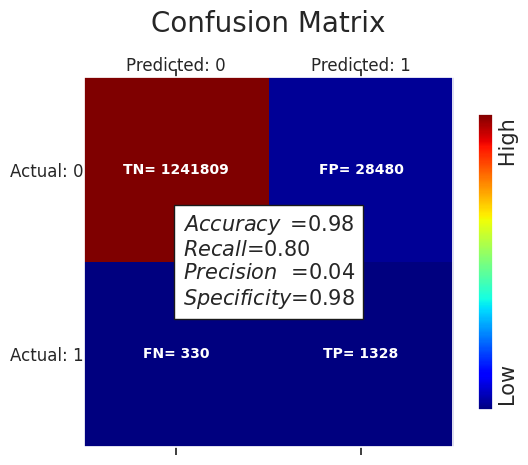

In [ ]:

ax1 = plt.axes()
im =ax1.matshow(conf_mx, cmap='jet', interpolation='nearest')
label = ['0','1']
x=[f'Predicted: {label[0]}', f'Predicted: {label[1]}']; y=[f'Actual: {label[0]}', f'Actual: {label[1]}']
ii=0
for (i, j), z in np.ndenumerate(conf_mx):
            if(ii==0): al='TN= '
            if(ii==1): al='FP= '
            if(ii==2): al='FN= '
            if(ii==3): al='TP= '

            ax1.text(j, i, al+'{:0.0f}'.format(z), color='w', ha='center', va='center', fontweight='bold',fontsize=10)
            ii=ii+1

txt='$ Accuracy\,\,\,$=%.2f\n$Recall$=%.2f\n$Precision\,\,\,\,$=%.2f\n$Specificity$=%.2f'
anchored_text = AnchoredText(txt %(acr,reca,prec,spec), loc=10, borderpad=0)
ax1.add_artist(anchored_text)

ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, fontsize=12,y=0.97, rotation='horizontal')

ax1.set_yticks(np.arange(len(y)))
ax1.set_yticklabels(y, fontsize=12,x=0.035, rotation='horizontal')

cbar =plt.colorbar(im,shrink=0.8,
                           label='Low                              High',orientation='vertical')
cbar.set_ticks([])
ax1.grid(visible=False )
plt.title('Confusion Matrix',fontsize=20,y=1.1)


Although the F1 Score is quite high, at 0.98, and the recall for the model is also quite high at 0.80, there are a large number of False Positives being identified.  

The precision indicates that only 4% of predicted fraudulent transactions were actually fraudulent, thus the potential client impact could be substantial when implemented.



## Extract feature importances by name

The function below was adapted from [this](https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator) page.  This function extracts the features, along with their relative importance in the model and returns it as a list to use.


In [ ]:
# Extract feature importances from a tree based model, including their names
def ExtractFeatureImp_spark(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = ('f' + varlist['idx'].astype('str')).apply(lambda x: featureImp.get(x))
    return(varlist.sort_values('score', ascending = False))

In [ ]:
print("Feature importances for the XGBoost model: \n")
Fimp = ExtractFeatureImp_spark(cv_xgb_model.bestModel.get_feature_importances(), train_model, "feature_vector")
Fimp.head(15)

Feature importances for the XGBoost model: 



,idx,name,score
15,15,log_amount,"8,599.00"
21,21,amt_diff_dest,"5,618.00"
17,17,log_prev_dest_avg_amount,"5,053.00"
11,11,prev_dest_txn_hour_avg,"4,988.00"
19,19,hour_diff_dest,"4,472.00"
13,13,prev_dest_steps_num,"3,607.00"
22,22,type_code_CASH_OUT,660.00
25,25,type_code_TRANSFER,610.00
46,46,txn_hour_code_19,387.00
40,40,txn_hour_code_13,352.00


Text(0.5, 1.0, 'Feature Importance')

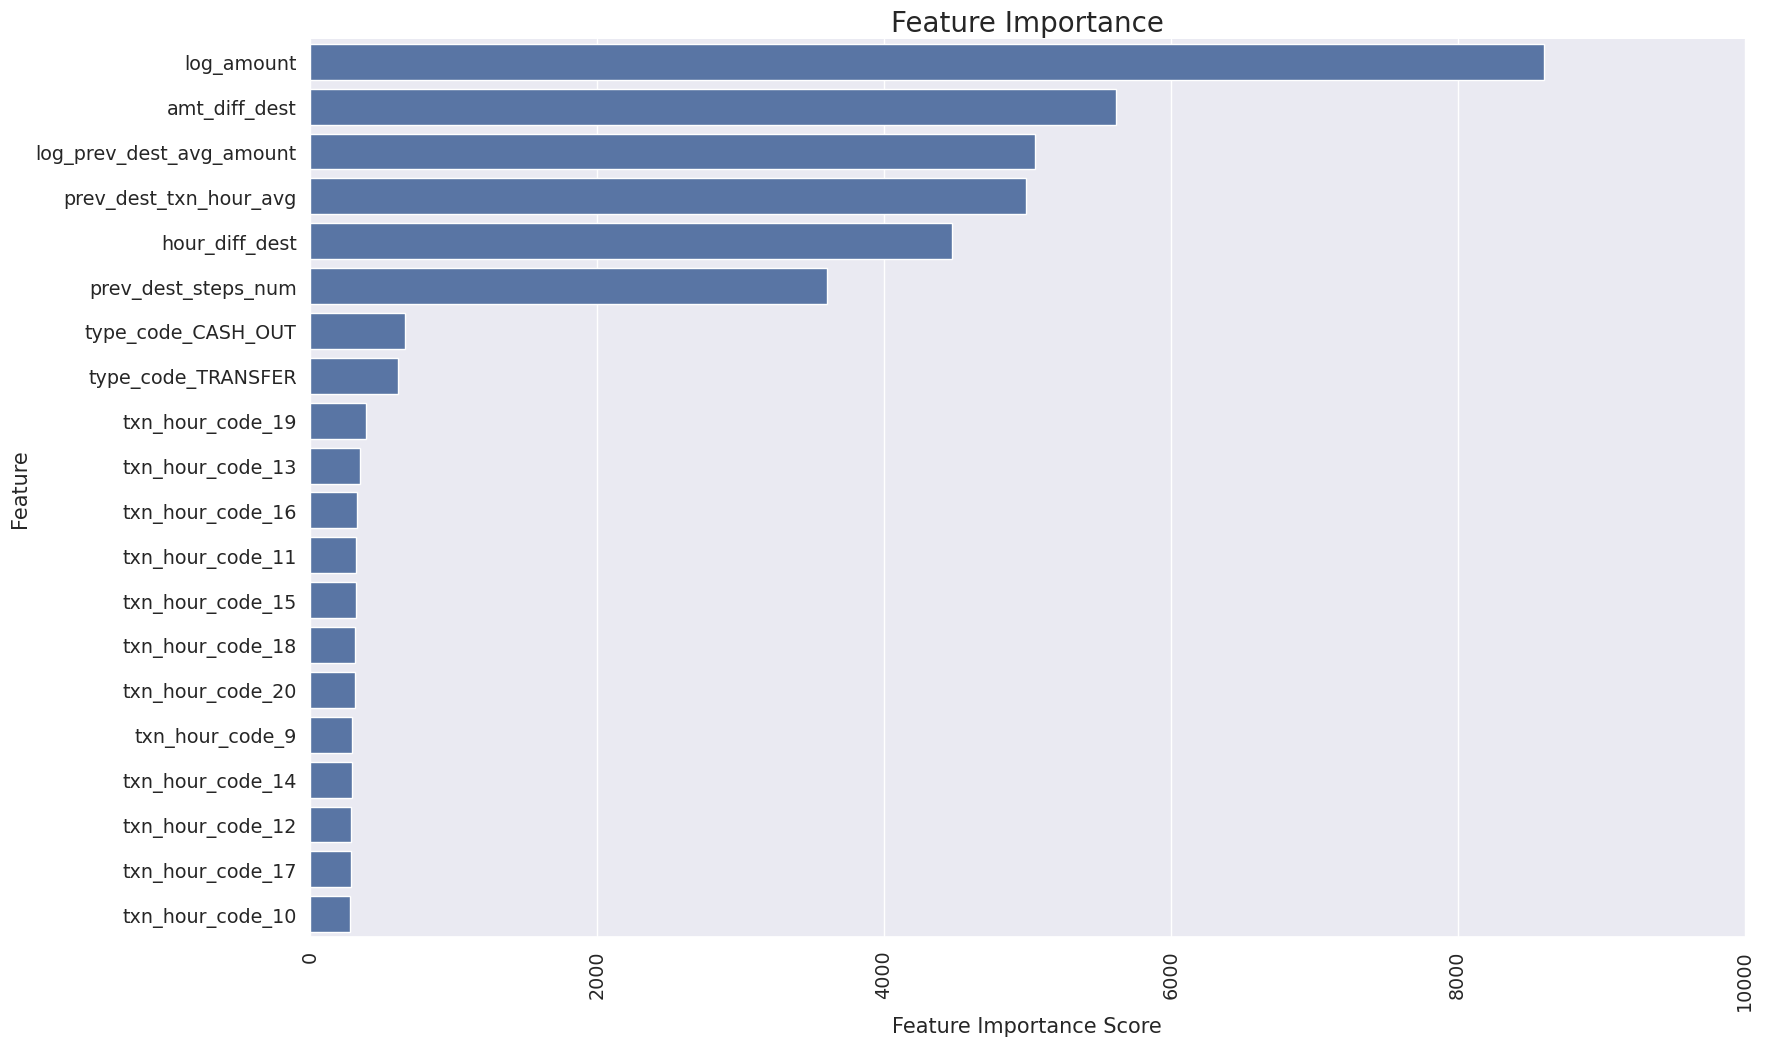

In [ ]:
fig =sns.catplot(data= Fimp.head(20),
            y='name',
            x='score',
            kind='bar', height=10, aspect=16/9)
fig.set_xticklabels(rotation=90)
fig.set_axis_labels("Feature Importance Score", "Feature")
plt.title("Feature Importance", size=20)

The Top 6 Features the model has considered as important are:

* **log_amount** : The log of the value of the transaction
* **amt_diff_dest** : How different the amount is compared to previous amounts paid to the same destination
* **prev_dest_txn_hour_avg** : What time of day previous transactions were made to the destiniation account
* **log_prev_dest_avg_amount** : The log of the average amount previously paid to the destination account
* **hour_diff_dest** : How different the time of the current transaction is compared to the general time the destination account generally recieves transactions.
* **prev_dest_steps_num** : How many transactions have been made to the destination account previously



Plotting the features not previously plotted will allow exploration of their relationship to the target feature.  Note that transformed versions of some features are plotted to aid in interprtability, especially for amount fetures.

In [ ]:
# sample a pandas dataframe from the original data
# dfp = test_model.sample(fraction=0.16, seed = seed).toPandas()
dfp = test_model.toPandas()
dfp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,merchOrig,merchDest,merchInvolved,txn_hour,origBalanceCleared,orig_nameOrig,orig_step,prev_orig_merchInvolved_total,prev_orig_fraud_max,prev_orig_txn_hour_avg,prev_orig_merchDest_sum,prev_orig_avg_amount,prev_orig_steps_num,prev_orig_merch_orig_sum,dest_nameDest,dest_step,prev_dest_merchInvolved_total,prev_dest_fraud_max,prev_dest_txn_hour_avg,prev_dest_merchDest_sum,prev_dest_avg_amount,prev_dest_steps_num,prev_dest_merch_orig_sum,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest,log_amount,log_prev_orig_avg_amount,log_prev_dest_avg_amount,hour_diff_orig,hour_diff_dest,amt_diff_orig,amt_diff_dest,type_idx,type_code,txn_hour_code,feature_vector
0,1,CASH_IN,"9,467.87",C1903051549,"6,071.00","15,538.87",C373928166,0.00,0.00,0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,8.71,9.65,0.00,0.00,9.16,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,CASH_IN,"30,811.56",C1946111918,"7,243,811.00","7,274,622.50",C22805895,"152,178.00","651,524.94",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.80,15.80,11.93,13.39,10.34,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,CASH_IN,"91,457.82",C1531200408,"6,718,610.00","6,810,068.00",C1509514333,"662,260.25","2,415.16",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.72,15.73,13.40,7.79,11.42,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,CASH_IN,"110,226.34",C1475192960,"1,601,450.62","1,601,450.62",C1816757085,"1,601,450.62","10,681,239.00",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,14.29,14.29,14.29,16.18,11.61,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,CASH_IN,"112,637.63",C614635686,"3,551,607.25","3,664,244.75",C22805895,"808,818.00","651,524.94",0,0,0,0,0,1,0,None,0,0,0,0.00,0,0.00,0,0,None,0,0,0,0.00,0,0.00,0,0,15.08,15.11,13.60,13.39,11.63,0.00,0.00,0.00,0.00,0.00,0.00,2.00,"(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
dfp_fraud    = dfp[dfp['isFraud'] == 1]
dfp_nonfraud = dfp[dfp['isFraud'] == 0]

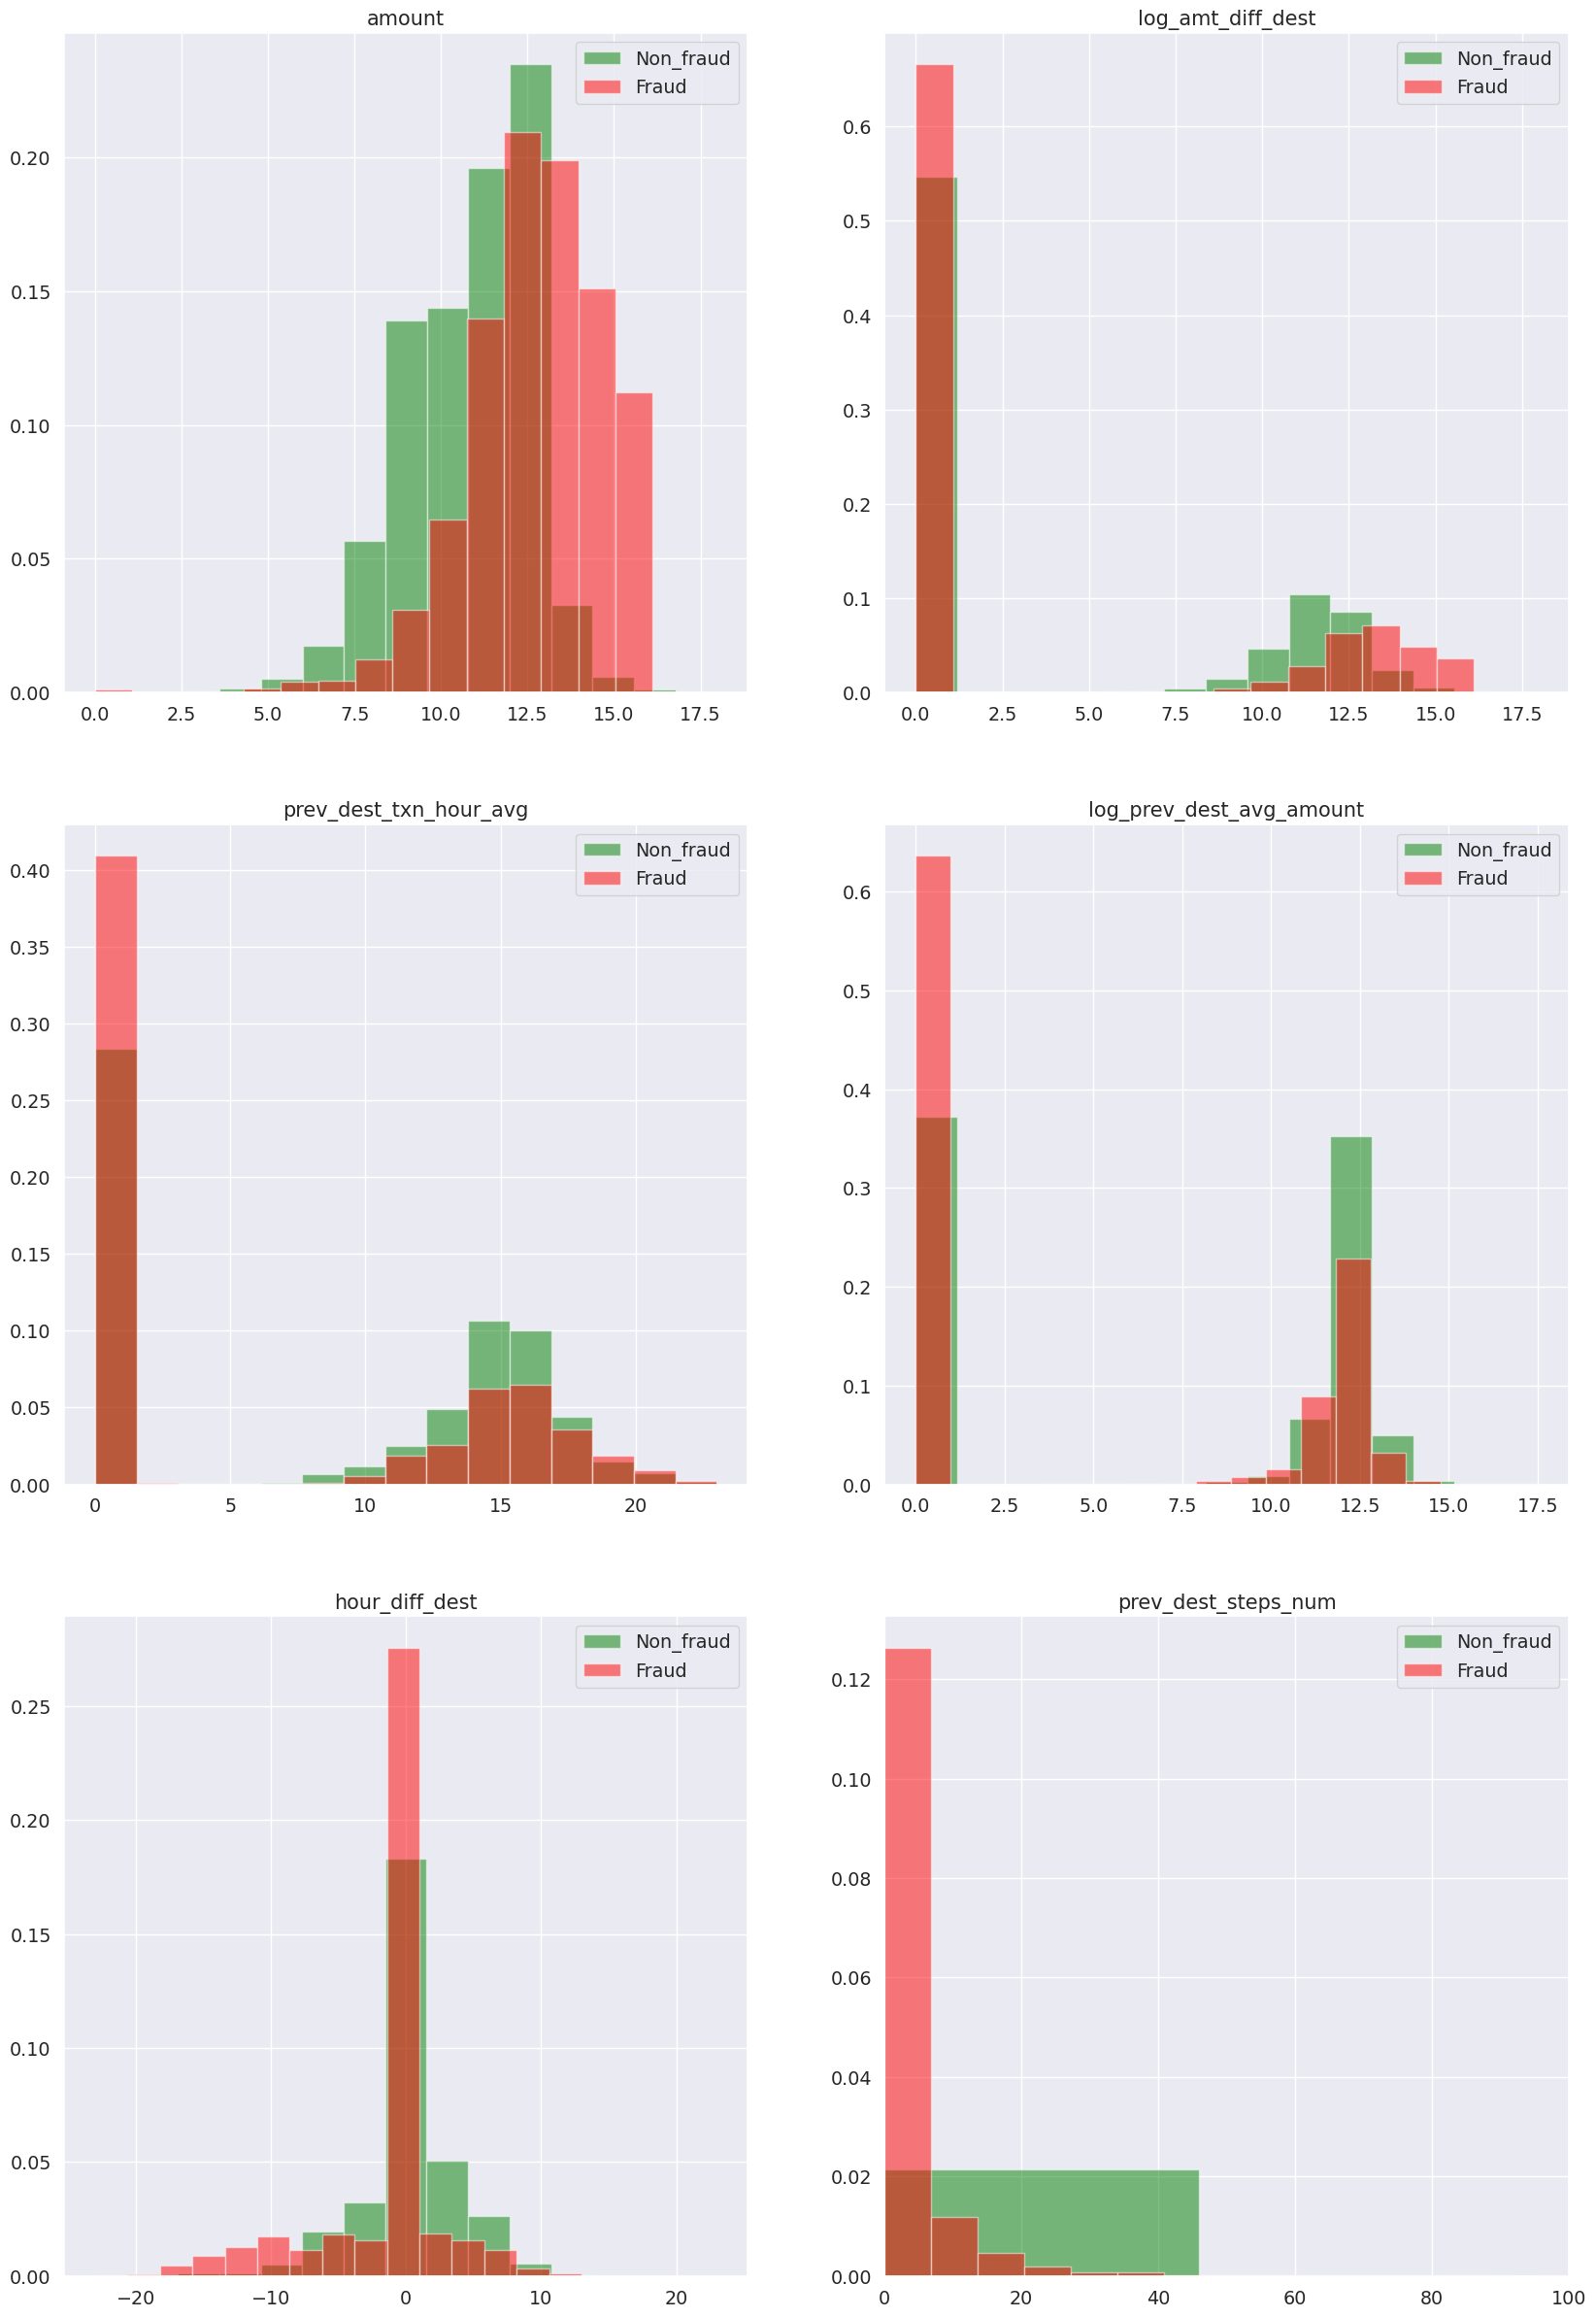

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(20, 30), sharey = False)

axs[0, 0].hist((dfp_nonfraud['log_amount'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 0].hist((dfp_fraud['log_amount'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 0].set_title('amount')
axs[0, 0].legend()

axs[0, 1].hist((dfp_nonfraud['amt_diff_dest'] + 1).apply(np.log), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[0, 1].hist((dfp_fraud['amt_diff_dest'] + 1).apply(np.log), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[0, 1].set_title('log_amt_diff_dest')
axs[0, 1].legend()

axs[1, 0].hist((dfp_nonfraud['prev_dest_txn_hour_avg'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 0].hist((dfp_fraud['prev_dest_txn_hour_avg'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 0].set_title('prev_dest_txn_hour_avg')
axs[1, 0].legend()

axs[1, 1].hist((dfp_nonfraud['log_prev_dest_avg_amount'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[1, 1].hist((dfp_fraud['log_prev_dest_avg_amount'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[1, 1].set_title('log_prev_dest_avg_amount')
axs[1, 1].legend()

axs[2, 0].hist((dfp_nonfraud['hour_diff_dest'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[2, 0].hist((dfp_fraud['hour_diff_dest'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 0].set_title('hour_diff_dest')
axs[2, 0].legend()

axs[2, 1].hist((dfp_nonfraud['prev_dest_steps_num'] ), bins=bins, color='green', alpha=0.5, label='Non_fraud', density=True)
axs[2, 1].hist((dfp_fraud['prev_dest_steps_num'] ), bins=bins, color='red', alpha=0.5, label='Fraud', density=True)
axs[2, 1].set_xlim(0,100)
axs[2, 1].set_title('prev_dest_steps_num')
axs[2, 1].legend()

Interpretation of Top 6 most important features:  

* **log_amount** : The distribution of the fraudulent transactions indicate that they tend to have higher average transaction amounts.
* **amt_diff_dest** : The fraudulent transactions going to the same destinations tend to have similar or a lot higher amounts.
* **prev_dest_txn_hour_avg** : Fraudulent transactions tend to occur at the early hours of the morning to the destination accounts, although not exclusively.
* **log_prev_dest_avg_amount** : The destination accounts receiving fraudulent transactions tend to not have any previous transactions.
* **hour_diff_dest** : Fraudulent destination accounts tend not to have previous transactions, thus the average difference tend to be 0.  In cases where there were previous transactions, they tend to occur earlier in the day compared to their normal transactional behaviour.
* **prev_dest_steps_num** : Fraudulent destination accounts tend not to have previous transactions, however when they do, their previous transactions tend to happen earlier in the morning.

In [ ]:
# Release memory of pandas datasets
del(dfp)
del(dfp_nonfraud)
del(dfp_fraud)



---



# **Tuning Model Threshold**

## Precision / Recall

Considering the current precision of the model, I would also like to investigate whether there might be other prediction thresholds (vs the current 0.5), that might have a better tradeoff when it comes to precision and recall.  
  
For this, we plot and examine the precision and recall compared to the various thresholds of the model.

In [ ]:
# import necessary package
from sklearn.metrics import precision_recall_curve
# Define a helper function to assist in the plotting
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x=0.8):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "y-", label="Sensitivity", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Precision/Sensitivity", fontsize=12)
    plt.title("Precision and Sensitivity versus Threshold", fontsize=12)
    plt.grid(linewidth='0.25')
    plt.axvline(x=x,linestyle='--',color='k',label='Probability '+str(np.round(x,2)))
    plt.legend(loc=3, ncol=3,fontsize=10,markerscale=1.2, edgecolor="black",framealpha=0.9)
    plt.axis([0, 1, 0, 1])

In [ ]:
 # select the prediction, probability and label columns
preds = predictions_test_xgb.select(['rawPrediction','isFraud', 'prediction', 'probability'])\
                                      .withColumn('label', F.col('isFraud')\
                                      .cast(FloatType())).orderBy('prediction')
preds.show(5)

+--------------------+-------+----------+--------------------+-----+
|       rawPrediction|isFraud|prediction|         probability|label|
+--------------------+-------+----------+--------------------+-----+
|[4.16769647598266...|      0|       0.0|[0.98474830389022...|  0.0|
|[6.44656896591186...|      0|       0.0|[0.99841654300689...|  0.0|
|[5.41357803344726...|      0|       0.0|[0.99556410312652...|  0.0|
|[5.08910465240478...|      0|       0.0|[0.99387419223785...|  0.0|
|[5.44740104675293...|      0|       0.0|[0.99571096897125...|  0.0|
+--------------------+-------+----------+--------------------+-----+
only showing top 5 rows



In [ ]:
# Define a UDF to extract the probability of the positive class
extract_probability_udf = udf(lambda v: float(v[1]), FloatType())

In [ ]:
%%time
# Commented out to prevent accidental rerunning
num_thresholds = 100
thresholds = np.linspace(0.01, 0.99, num_thresholds)
df_metrics = pd.DataFrame(columns=['recall', 'precision', 'threshold', 'accuracy'])

for thresh in thresholds:
  predictions_with_threshold = preds.withColumn(
        "predictedLabel_tuned",
        when(extract_probability_udf(col("probability")) > thresh, 1.0).otherwise(0.0) # Cast to Double for evaluator compatibility
    )
  metrics_thresh = MulticlassMetrics(predictions_with_threshold.select(['predictedLabel_tuned','label']).rdd.map(tuple))
  reca_thresh = metrics_thresh.recall(1.0)
  prec_thresh = metrics_thresh.precision(1.0)
  accr = metrics.accuracy
  df_metrics = pd.concat([df_metrics, pd.DataFrame({'recall': [reca_thresh], 'precision': [prec_thresh], 'threshold': [thresh], 'accuracy': [accr]})],  ignore_index=True)
  # print("Last Threshold loaded: ", thresh)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
<timed exec>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Last Threshold loaded:  0.01
Last Threshold loaded:  0.0198989898989899
Last Threshold loaded:  0.029797979797979796
Last Threshold loaded:  0.039696969696969696
Last Threshold loaded:  0.049595959595959596
Last Threshold loaded:  0.059494949494949496
Last Threshold loaded:  0.06939393939393938
Last Threshold loaded:  0.07929292929292929
Last Threshold loaded:  0.08919191919191918
Last Threshold loaded:  0.09909090909090908
Last Threshold loaded:  0.10898989898989898
Last Threshold loaded:  0.11888888888888888
Last Threshold loaded:  0.12878787878787878
Last Threshold loaded:  0.1386868686868687
Last Threshold loaded:  0.1485858585858586
Last Threshold loaded:  0.15848484848484848
Last Threshold loaded:  0.16838383838383839
Last Threshold loaded:  0.1782828282828283
Last Threshold loaded:  0.18818181818181817
Last Threshold loaded:  0.19808080808080808
Last Threshold loaded:  0.207979797979798
Last Threshold loaded:  0.21787878787878787
Last Threshold loaded:  0.22777777777777777
Last 

In [ ]:
df_metrics

,recall,precision,threshold,accuracy
0,0.97,0.00,0.01,0.98
1,0.95,0.01,0.02,0.98
2,0.93,0.01,0.03,0.98
3,0.92,0.01,0.04,0.98
4,0.91,0.01,0.05,0.98
...,...,...,...,...
95,0.67,0.11,0.95,0.98
96,0.63,0.13,0.96,0.98
97,0.60,0.16,0.97,0.98
98,0.53,0.23,0.98,0.98


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x=0.5):
    plt.plot(thresholds, precisions, "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls, "y-", label="Sensitivity", linewidth=2)
    plt.legend(loc="center right", fontsize=12)
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Precision/Sensitivity", fontsize=12)
    plt.title("Precision and Sensitivity versus Threshold", fontsize=12)
    plt.grid(linewidth='0.25')
    plt.axvline(x=x,linestyle='--',color='k',label='Probability '+str(np.round(x,2)))
    plt.legend(loc=3, ncol=3,fontsize=10, markerscale=1.2, edgecolor="black",framealpha=0.9)
    plt.axis([0, 1, 0, 1])

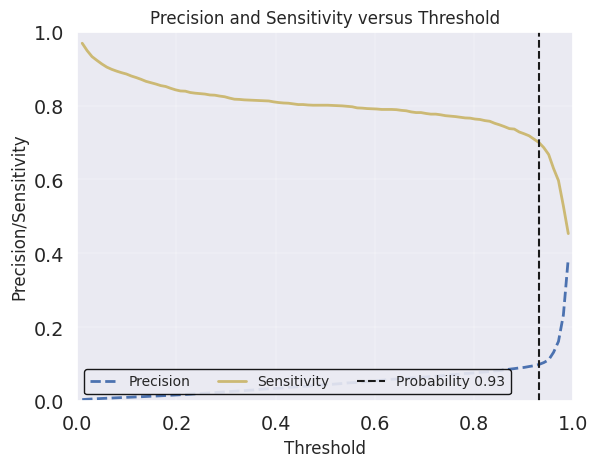

In [ ]:
plot_precision_recall_vs_threshold(df_metrics['precision'], df_metrics['recall'], df_metrics['threshold'], x=0.93)

The threshold of 0.93 was selected as an inflection point, as that is the point where the Precision reached 10%.  

In [ ]:
predictions_with_threshold = preds.withColumn(
        "predictedLabel_tuned",
        when(extract_probability_udf(col("probability")) > 0.93, 1.0).otherwise(0.0) # Cast to Double for evaluator compatibility
    )
metrics_thresh = MulticlassMetrics(predictions_with_threshold.select(['predictedLabel_tuned','label']).rdd.map(tuple))
reca_thresh = metrics_thresh.recall(1.0)
prec_thresh = metrics_thresh.precision(1.0)
accr = metrics_thresh.accuracy
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'recall': [reca_thresh], 'precision': [prec_thresh], 'threshold': [thresh], 'accuracy', [accr]})],  ignore_index=True)


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
conf_thresh = metrics_thresh.confusionMatrix().toArray()
print(conf_thresh)

[[ 1259752.000  10537.000]
 [ 497.000  1161.000]]


Text(0.5, 1.1, 'Confusion Matrix - Tuned @ 0.93')

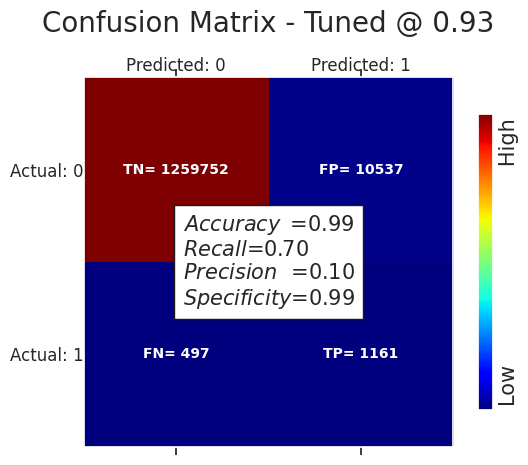

In [ ]:

del im, ax1

TP = conf_thresh[1][1]
TN = conf_thresh[0][0]
FP = conf_thresh[0][1]
FN = conf_thresh[1][0]

acr = accr
reca = reca_thresh
prec = prec_thresh
spec= TN/(TN+FP)

ax1 = plt.axes()
im =ax1.matshow(conf_thresh, cmap='jet', interpolation='nearest')
label = ['0','1']
x=[f'Predicted: {label[0]}', f'Predicted: {label[1]}']; y=[f'Actual: {label[0]}', f'Actual: {label[1]}']
ii=0
for (i, j), z in np.ndenumerate(conf_thresh):
            if(ii==0): al='TN= '
            if(ii==1): al='FP= '
            if(ii==2): al='FN= '
            if(ii==3): al='TP= '

            ax1.text(j, i, al+'{:0.0f}'.format(z), color='w', ha='center', va='center', fontweight='bold',fontsize=10)
            ii=ii+1

txt='$ Accuracy\,\,\,$=%.2f\n$Recall$=%.2f\n$Precision\,\,\,\,$=%.2f\n$Specificity$=%.2f'
anchored_text = AnchoredText(txt %(acr,reca,prec,spec), loc=10, borderpad=0)
ax1.add_artist(anchored_text)

ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x, fontsize=12,y=0.97, rotation='horizontal')

ax1.set_yticks(np.arange(len(y)))
ax1.set_yticklabels(y, fontsize=12,x=0.035, rotation='horizontal')

cbar =plt.colorbar(im,shrink=0.8,
                           label='Low                              High',orientation='vertical')
cbar.set_ticks([])
ax1.grid(visible=False )
plt.title('Confusion Matrix - Tuned @ 0.93',fontsize=20,y=1.1)


The adjustment of the threshold from 0.5 to 0.93, allows the number of false positives to reduce substantially from \~28 000 to \~10 000 (~33% decrease), while allowing the false negatives to increase from 330 to 497 (a ~50% increase).  
  
This would mean a decrease in operational costs of investigating False postives, or inconveniencing clients based on Falsly flagging the transaction as fraud, however fraud losses will increase when using this method as is.  

A better method would be to quantify the impact of each false positive and each false negative, to determine which threshold to use.

## Cost of decisions

The cost of making a wrong prediction is not the same in each scenario.  Consider the following:  



*   Predicting a transaction as fraudulent, when it is not (False Positive):  
    There are costs involved in investigating the transaction and potentially liasing with a client for a period of time.  Clients might still transact with the company and could consider this as protection of their funds.
      
*   Predicting a transaction as NOT fraudulent, when it is (False Negative):
    Costs of absorbing the cost of the transaction on behalf of the client, cost of investigating the transaction, loss of reputation/trust as transactions cannot be trusted as a whole.  This could lead to loss of a client as a whole, with no future transactions happening.

These costs are clearly not the same, as one could lead to client loss.  False positives could be managed in the general operational workflow, with confirmation being requested from the client digitally once flagged.  This would also allow the capture of the true fraudulent events ocurring.


In the absence of true cost availability for each decision, a good approximation would be to use the median transaction amount (179 861) as a cost metric, since the amount may need to be absorbed entirely in the event of a false negative, in an effort to maintain the relationship with a client.  Also note that the average a

Thus, assume the following costs are associated with each decision:  



*   False Positive:  
    25% of the median transaction amount, to account for operational costs of potentially up with a client:   **18 716**
*   False Negative:
    250% of the median transaction amount, to account for absorbing of the full transaction amount, potential loss of reputation and investigation costs:  **187 160**
*   True Positive:
    Negative of the median transaction amount, as it would account for the capture of the actual fraudulent cases that actually DECREASE costs:  **-74 864**
*   True Negative:  
    No cost is assigned to the True negatives, as there should be no more costs assigned based on the decision, if no benefit or cost arises:  **No cost**

In an ideal scenario, having profit assigned to each decision (even where no costs were involved), would yield the best results, as currently, having no cost to True negatives would mean we minimise the cost by just classifying everything as as Negative (threshold of 1).  However in this scenario we assume that as not being possible.


This approximation leads to the following total costs:  
  
  
*Total Cost = (FP * cost of FP) + (FN * cost of FN) + (TP * cost of TP) + (TN * cost of TN)*




*   0.5 Threshold:  

    28 480 * 18 716 + 330 * 187 160 + (1 328 * -74 864) + 0 = **495 345 088**
*   0.93 Threshold:  

    10 537 * 18 716 + 497 * 187 160 + (1 161 * -74 864) + 0 = **203 311 908**  


The change of the threshold also reduced the estimated costs substantially, even though more False Negatives were flagged. Ideally, plotting this figure across a range of thresholds would be the best solution, thereby deciding where costs would be minimised (or profit maximised).
